In [1]:
rm(list=ls())
gc()
setwd("/hpc/group/pbenfeylab/CheWei/")

used    (Mb) gc trigger (Mb) max used (Mb)
Ncells  625269 33.4 1361470    72.8 1142193  61.0
Vcells 1159062  8.9 8388608    64.0 1802279  13.8

In [2]:
as.numeric(system("awk '/MemFree/ {print $2}' /proc/meminfo", intern=TRUE))

[1] 623416944

In [3]:
suppressMessages(library(Seurat))
suppressMessages(library(tricycle))
suppressMessages(library(cowplot))
suppressMessages(library(ggplot2))
suppressMessages(library(scattermore))
suppressMessages(library(scater))
suppressMessages(library(cowplot))
suppressMessages(library(RColorBrewer))
suppressMessages(library(grid))
suppressMessages(library(gplots))
suppressMessages(library(tidyverse))

prep <- function(seu){
seu$time.anno.Li.crude <- gsub("_.*$","",seu$time.celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Distal Columella","Distal Columella_Columella",seu$time.celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Distal Lateral Root Cap","Distal Lateral Root Cap_Lateral Root Cap",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Proximal Columella","Proximal Columella_Columella",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("Proximal Lateral Root Cap","Proximal Lateral Root Cap_Lateral Root Cap",seu$celltype.anno.Li.crude)
seu$celltype.anno.Li.crude <- gsub("^.*_","",seu$celltype.anno.Li.crude)
    return(seu)
}
plot_anno <- function(rc.integrated){
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Phloem","Protophloem", "Xylem", "Procambium","Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno.Li.crude <- factor(rc.integrated$celltype.anno.Li.crude, levels = order[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno.Li.crude),order))]
p1 <- DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno.Li.crude", cols=color)
p2 <- DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno.Li.crude", order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation", "Transition Domain", "Proliferation Domain"),
        cols = c('#F7E7B0','#FFC400','#2B871F','#005E3B',"#deebf7", "#3182bd", '#fee0d2','#de2d26'))
p3 <- DimPlot(rc.integrated, reduction = "umap", group.by = "consensus.time.group", cols=brewer.pal(10,"Spectral"))
p4 <- DimPlot(rc.integrated, reduction = "umap", group.by = "branch.anno")
options(repr.plot.width=16, repr.plot.height=12)
gl <- lapply(list(p1, p2, p3, p4), ggplotGrob)
gwidth <- do.call(unit.pmax, lapply(gl, "[[", "widths"))
gl <- lapply(gl, "[[<-", "widths", value = gwidth)
gridExtra::grid.arrange(grobs=gl, ncol=2)
}

In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: AlmaLinux 9.3 (Shamrock Pampas Cat)

Matrix products: default
BLAS/LAPACK: /hpc/group/pbenfeylab/ch416/miniconda3/envs/seu4/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.5.2               stringr_1.5.1              
 [3] dplyr_1.1.3                 purrr_1.0.2                
 [5] readr_2.1.3                 tidyr_1.3.0                
 [7] tibble_3.2.1                tidyverse_1.3.2            
 [9] g

## Load reference

In [5]:
new.ref <- readRDS("./tradeseq/Tricycle_Reference_Arabidopsis_Root.rds")

In [6]:
run_tricycle <- function(sample){
    seu <- readRDS(paste0("./COPILOT_other_projects/to_be_integrate/",sample,"_COPILOT.rds"))
    sce <- as.SingleCellExperiment(seu)
    
    ## Tricycle estimation
    sce <- project_cycle_space(sce,ref.m = new.ref)
    sce <- estimate_cycle_position(sce)
    
    sce$tricyclePosition <- (sce$tricyclePosition/pi) + 1.8
    sce$tricyclePosition[which(sce$tricyclePosition>=2)] <- sce$tricyclePosition[which(sce$tricyclePosition>=2)] - 2
    sce$tricyclePosition <- sce$tricyclePosition*pi
    
    ## Plot
    print(plot_ccposition_den(sce$tricyclePosition,
                    sce$orig.ident, 'sample',
                    bw = 10, fig.title = "Kernel density of \u03b8") +
      theme_bw(base_size = 14))
    
    ## Assign position to stage
    tricycleCCStage <- sce$tricyclePosition/pi

    G1_idx <- which(tricycleCCStage < 1 & tricycleCCStage >= 0)
    S_idx <- which(tricycleCCStage >= 1 & tricycleCCStage < 1.55)
    G2_idx <- which(tricycleCCStage >= 1.55 & tricycleCCStage <= 2)
                    
    tricycleCCStage[G1_idx]="G1/G0"
    tricycleCCStage[S_idx]="S"
    tricycleCCStage[G2_idx]="G2M"
    
    sce$tricycleCCStage <- tricycleCCStage
    
    ## Schwabe Stage
    #sce <- estimate_Schwabe_stage(sce,cycleGene.l = cc.gene.list)
    
    ## Table
    #seu$time.anno.Li <- gsub("_.*$","",seu$time.celltype.anno.Li)
    #print(table(seu$time.anno.Li, sce$tricycleCCStage))
    
    ## Prepare seu
    #seu <- prep(seu)
    #plot_anno(seu)
    
    ## Sce to seu
    seu$tricyclePosition <- sce$tricyclePosition/pi
    seu$tricycleCCStage <- sce$tricycleCCStage
    #seu$SchwabeCCStage <- sce$CCStage
    
    ## Tricycle position on umap
    p <- plot_emb_circle_scale(sce, dimred = "UMAP",
                           point.size = 1, point.alpha = 0.9) +
      theme_void(base_size = 14)
    legend <- circle_scale_legend(text.size = 5, alpha = 0.9)
    print(plot_grid(p, legend, ncol = 2, rel_widths = c(1, 0.5)))
    
    ## Write annotations as csv
    write.csv(seu@meta.data[,c("tricyclePosition", "tricycleCCStage")], paste0("./tricycle/",sample,".csv"), quote=FALSE)
    #saveRDS(seu,paste0("./scRNA-seq/Seurat_Objects/",sample,"_COPILOT_seu4.rds"))
}

In [12]:
sample.list <- c("sc_283","sc_284","sc_285","sc_286","sc_287","sc_288","sc_289","sc_290","sc_291","sc_292","sc_293","sc_294")

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


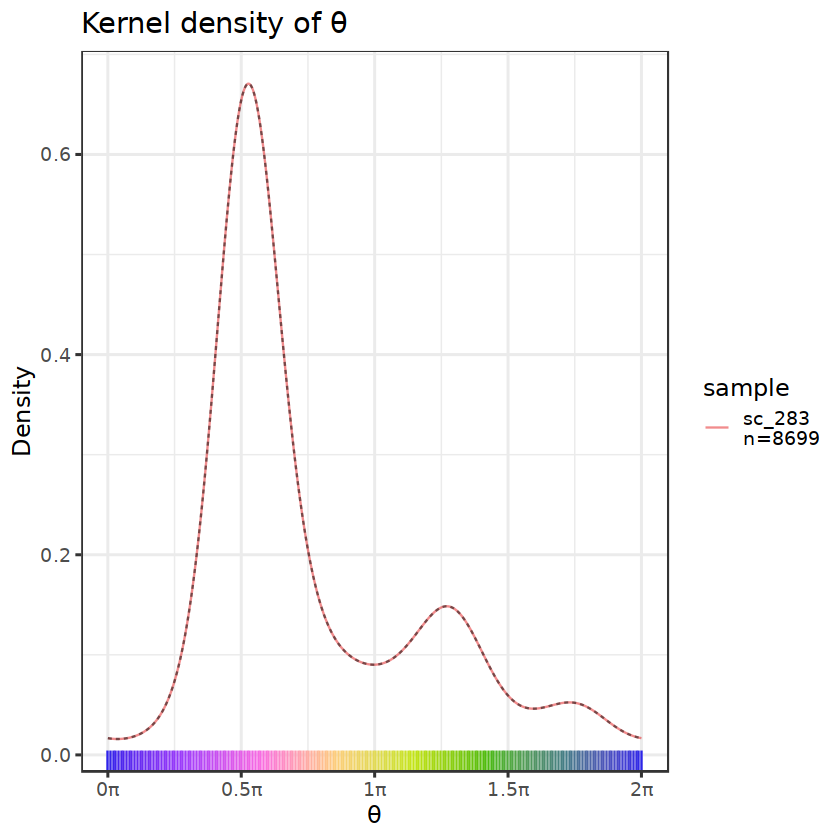

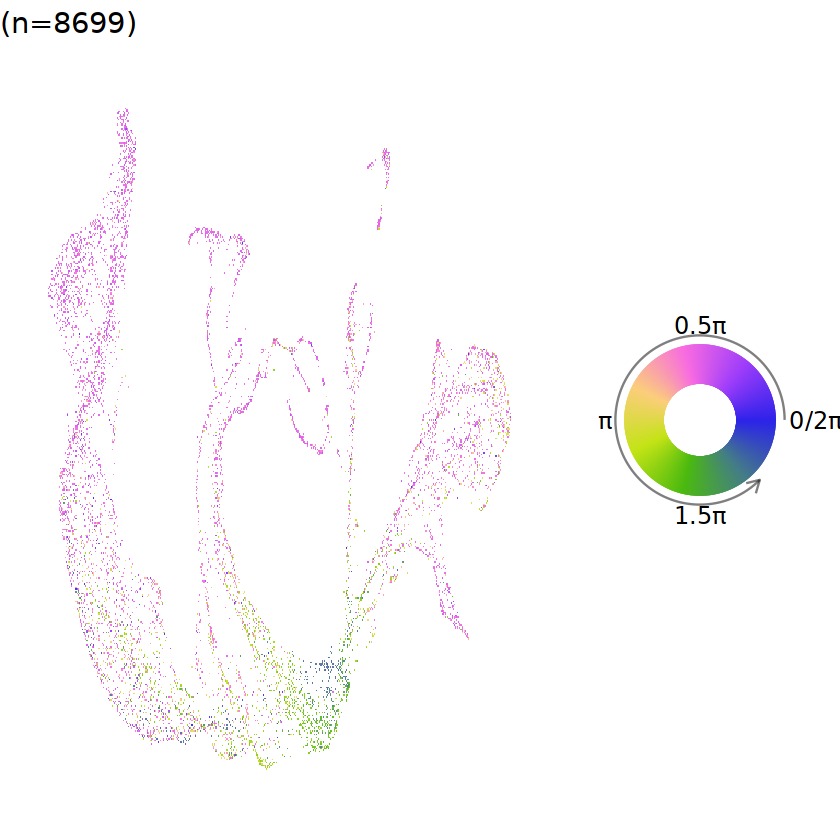

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


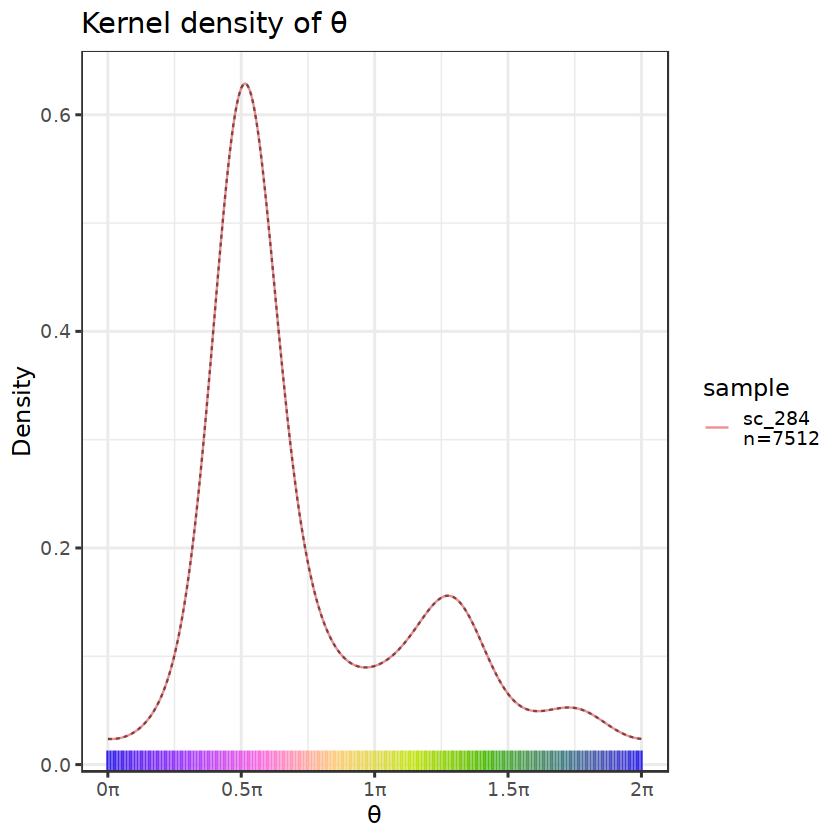

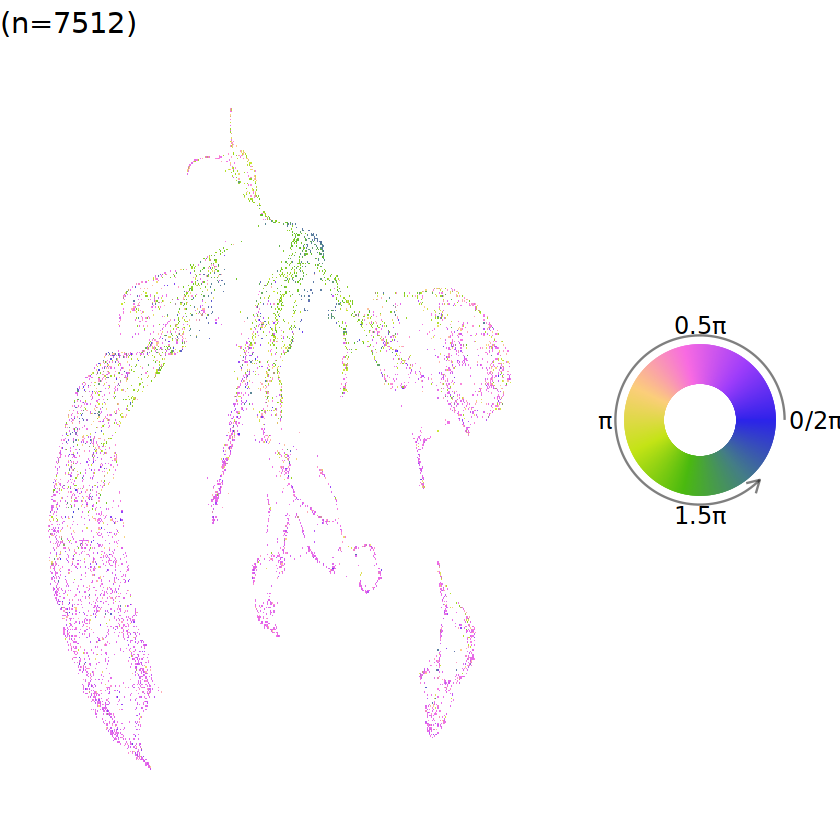

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


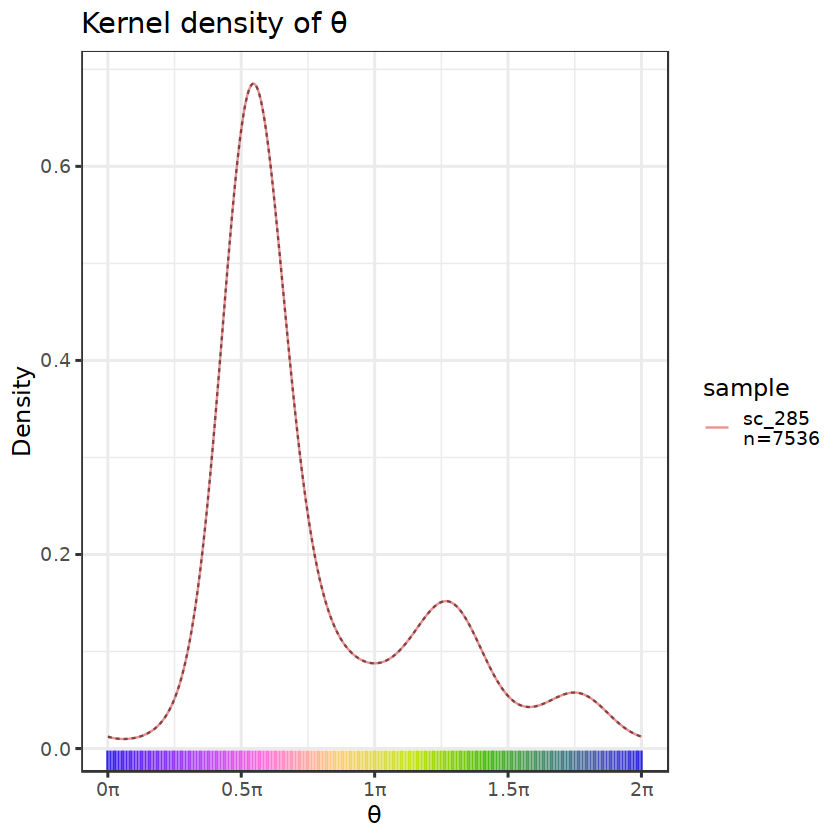

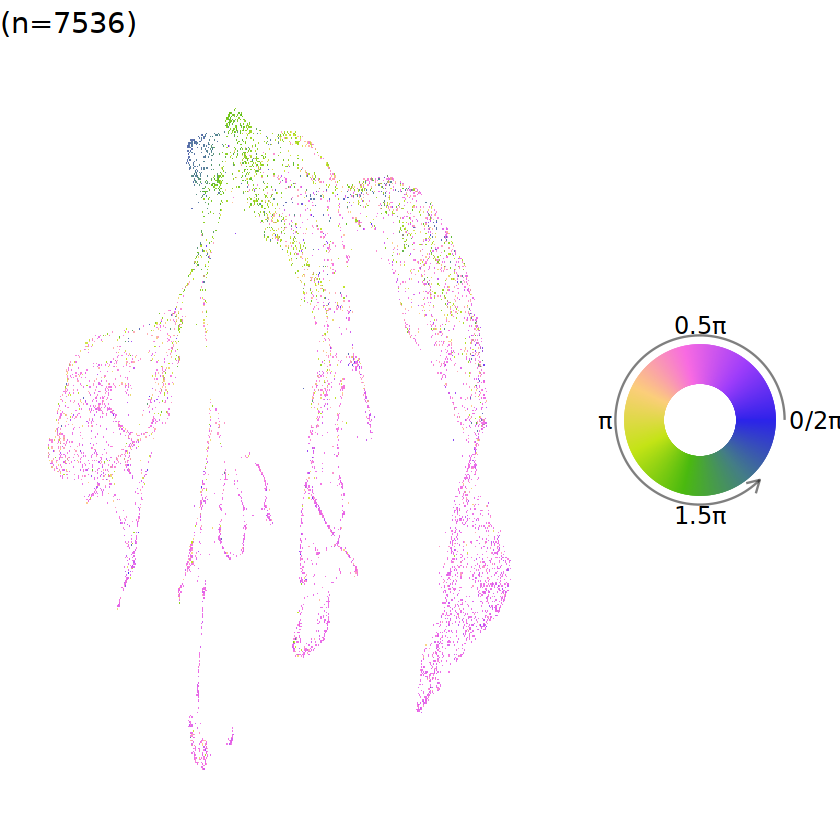

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


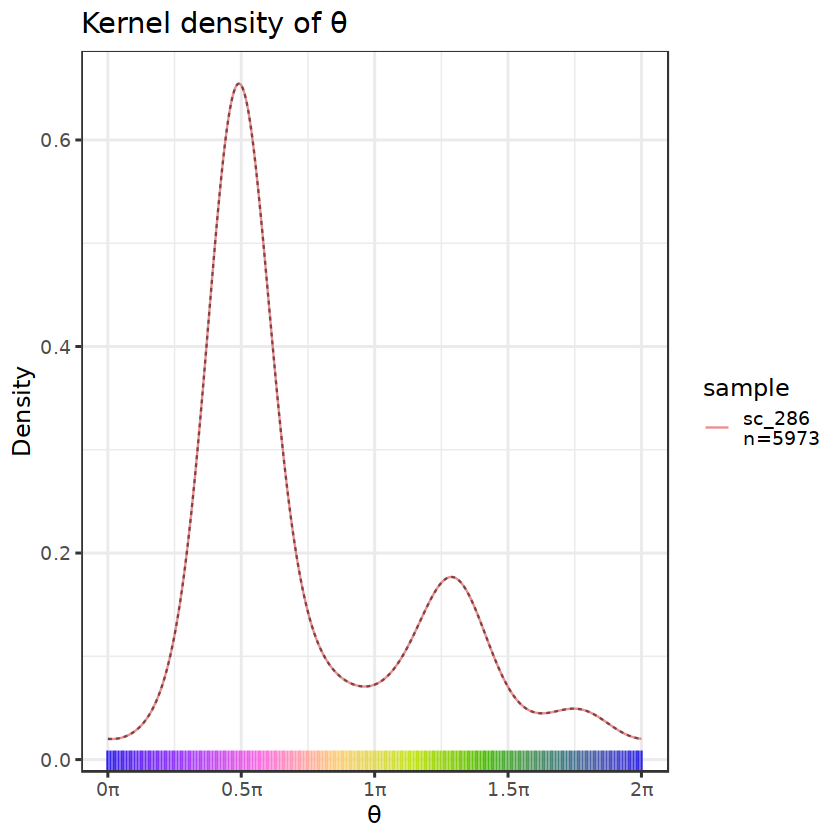

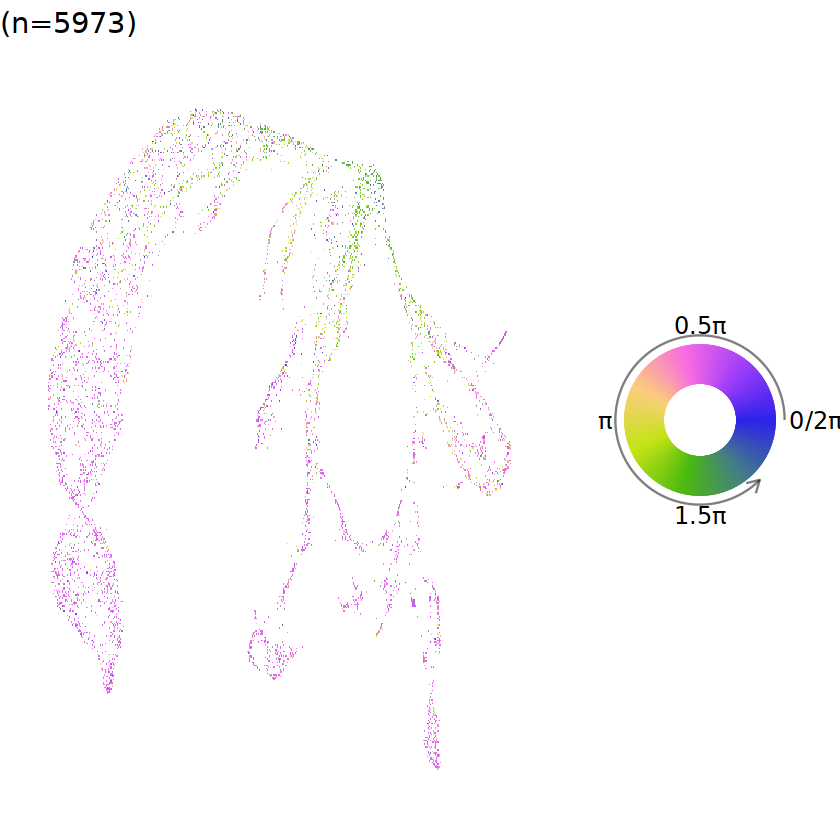

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


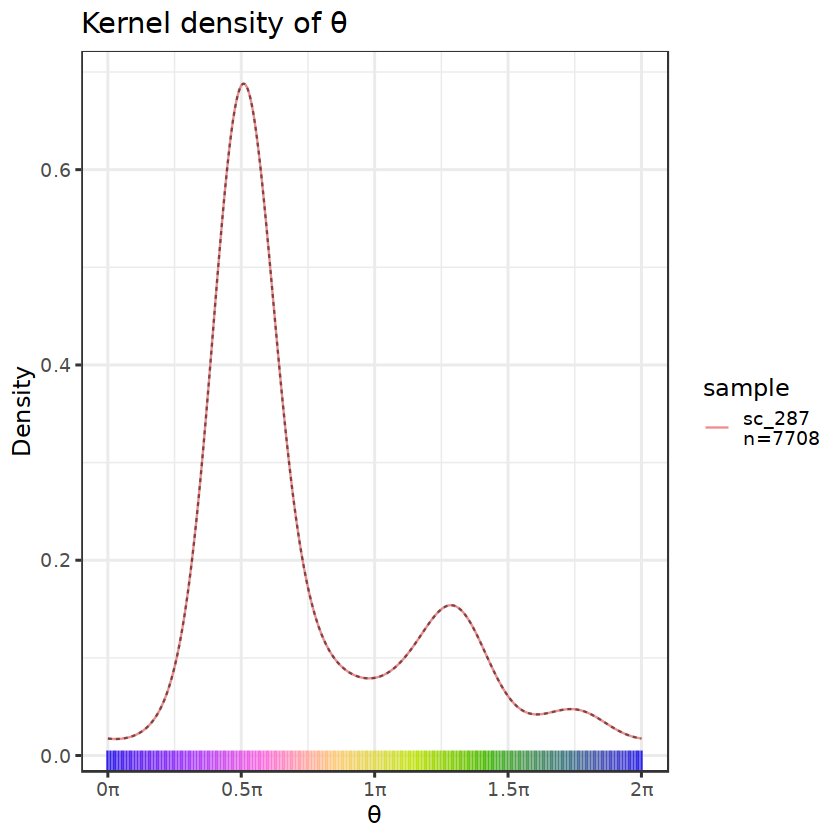

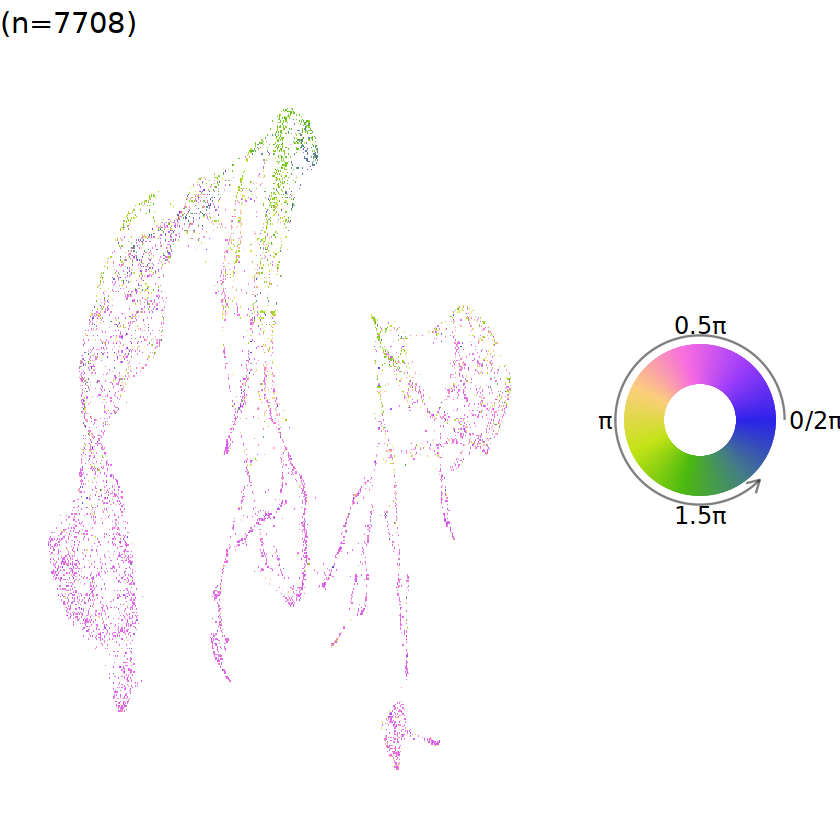

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


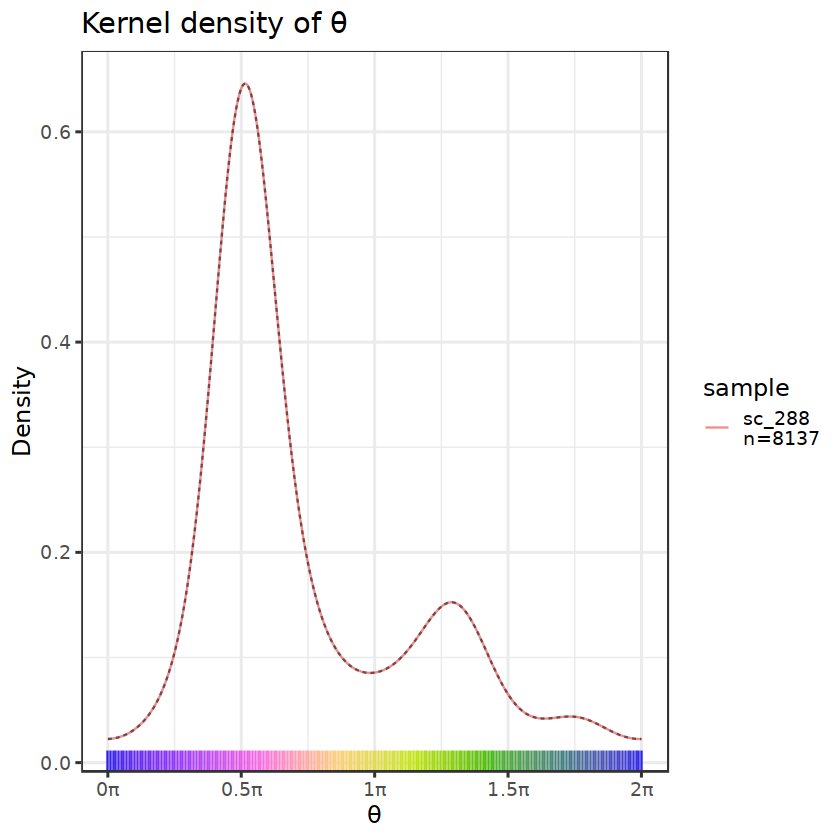

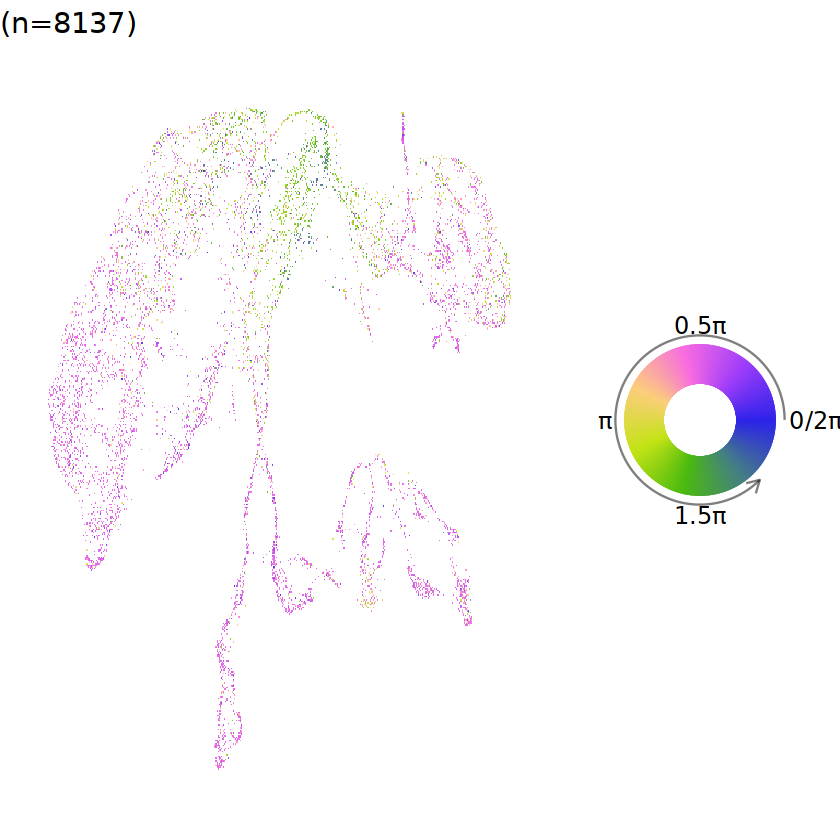

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


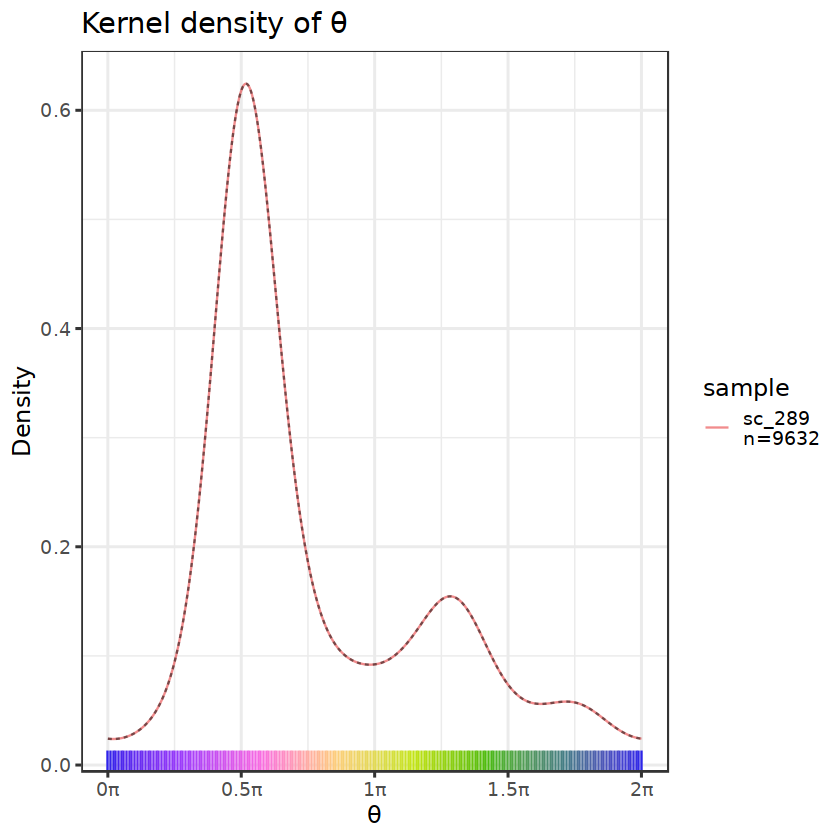

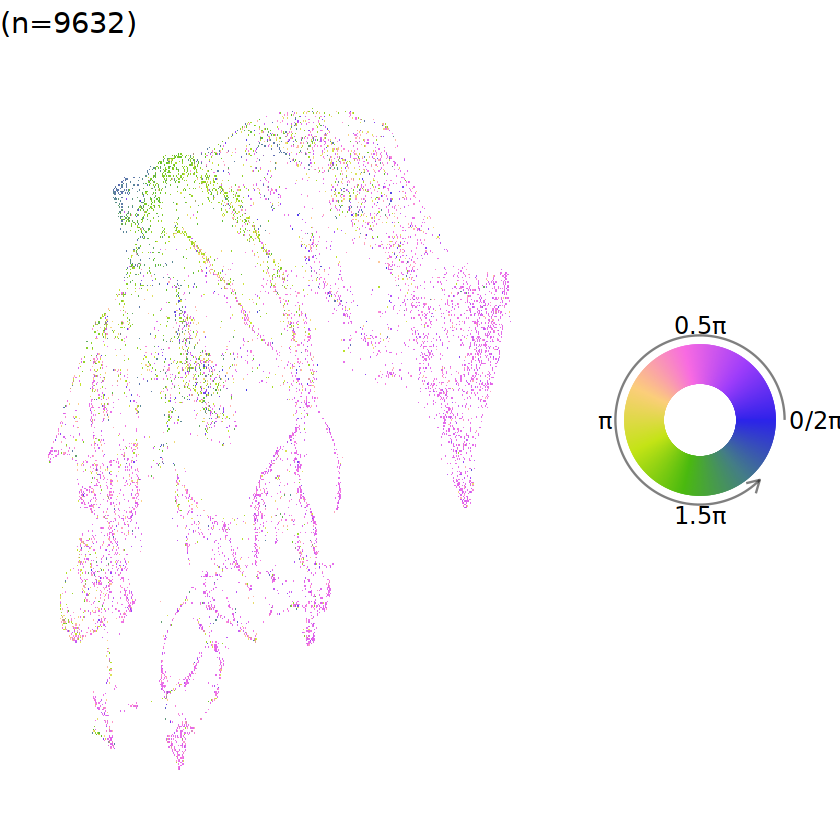

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


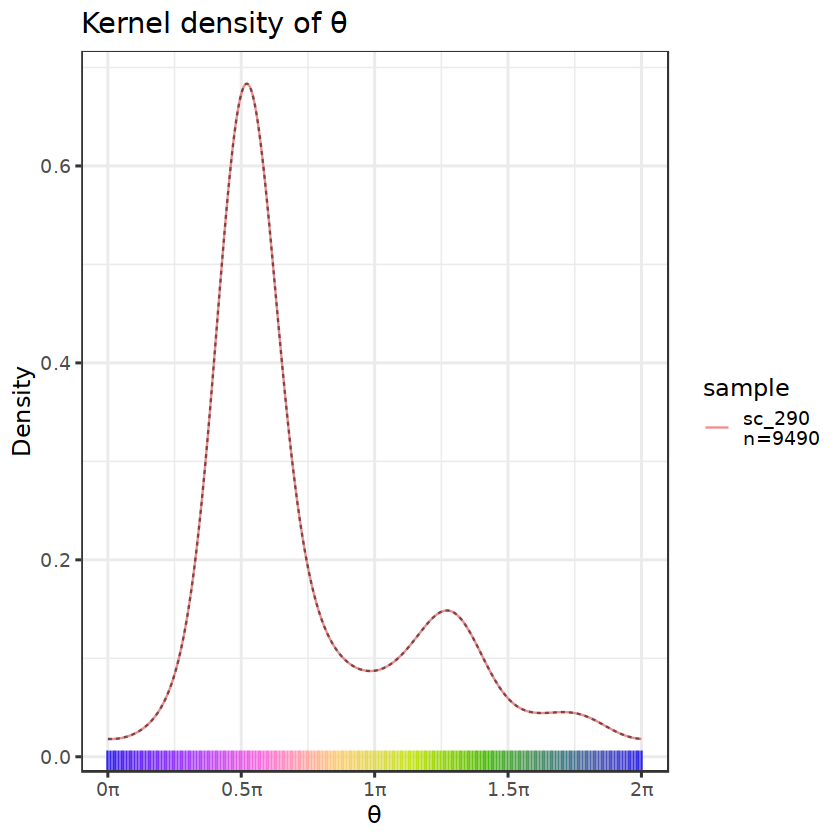

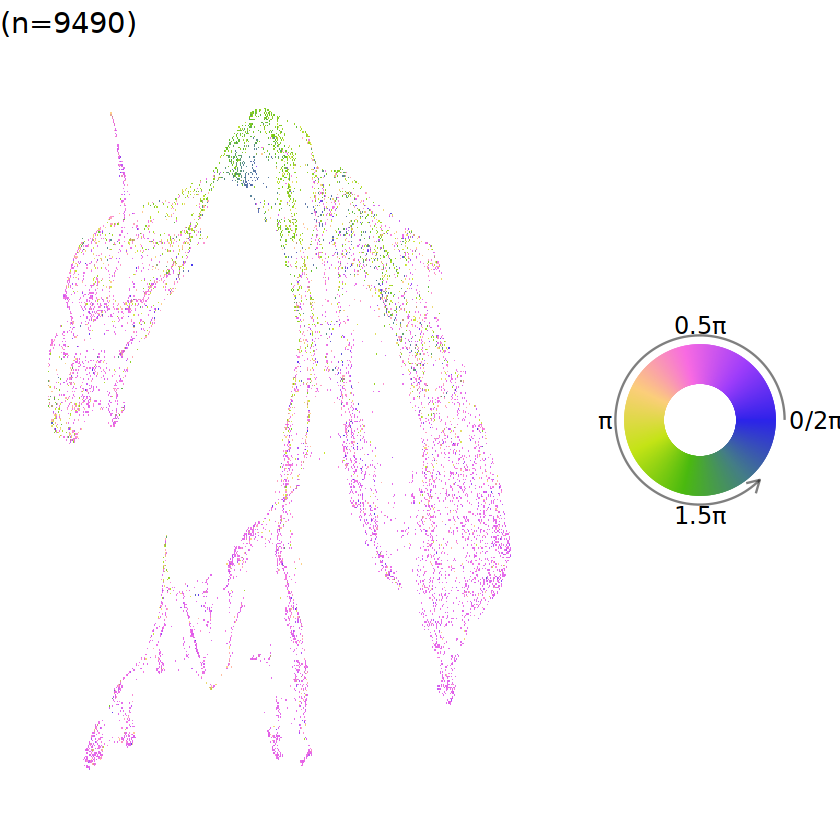

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


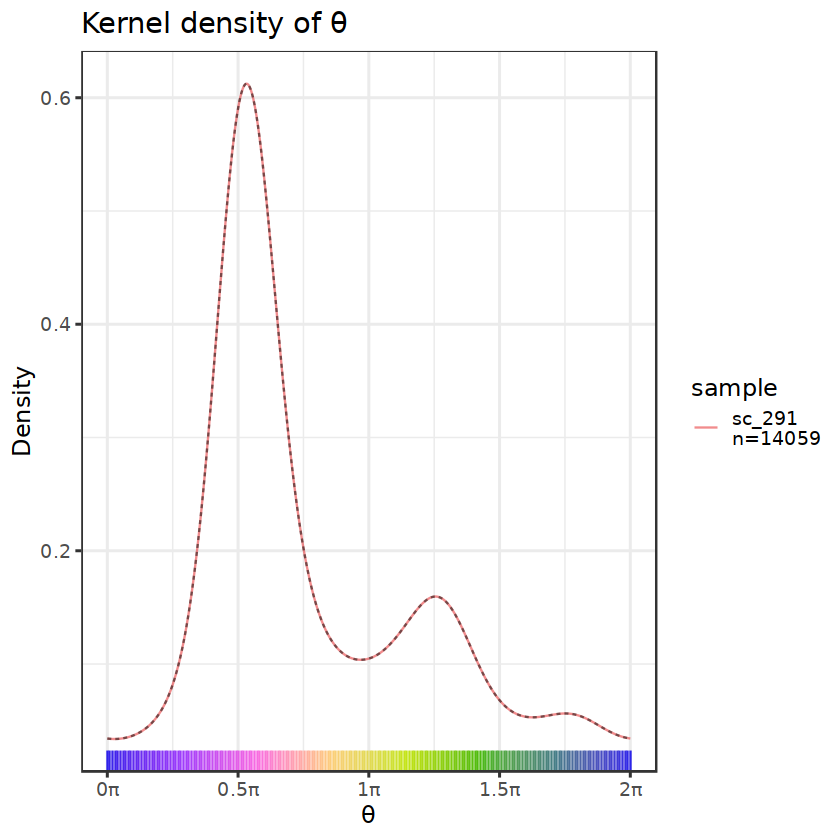

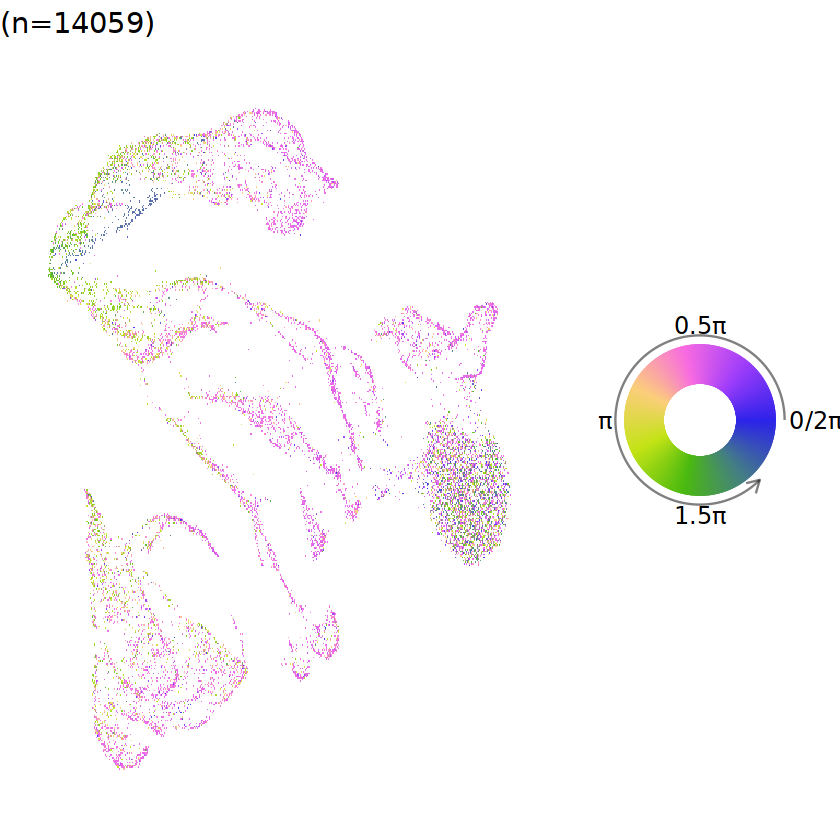

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


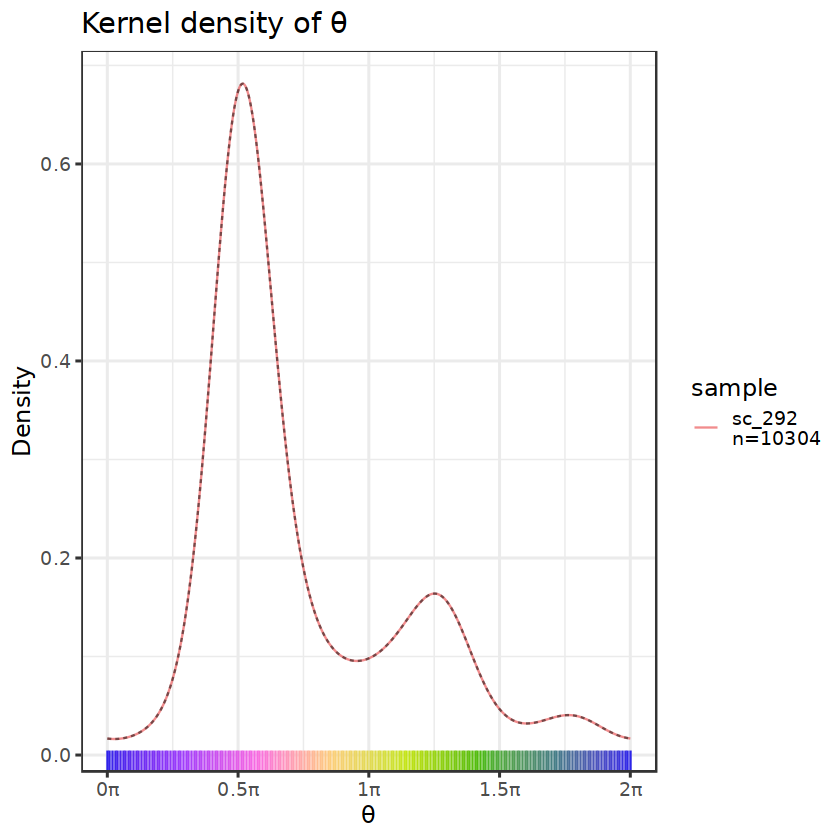

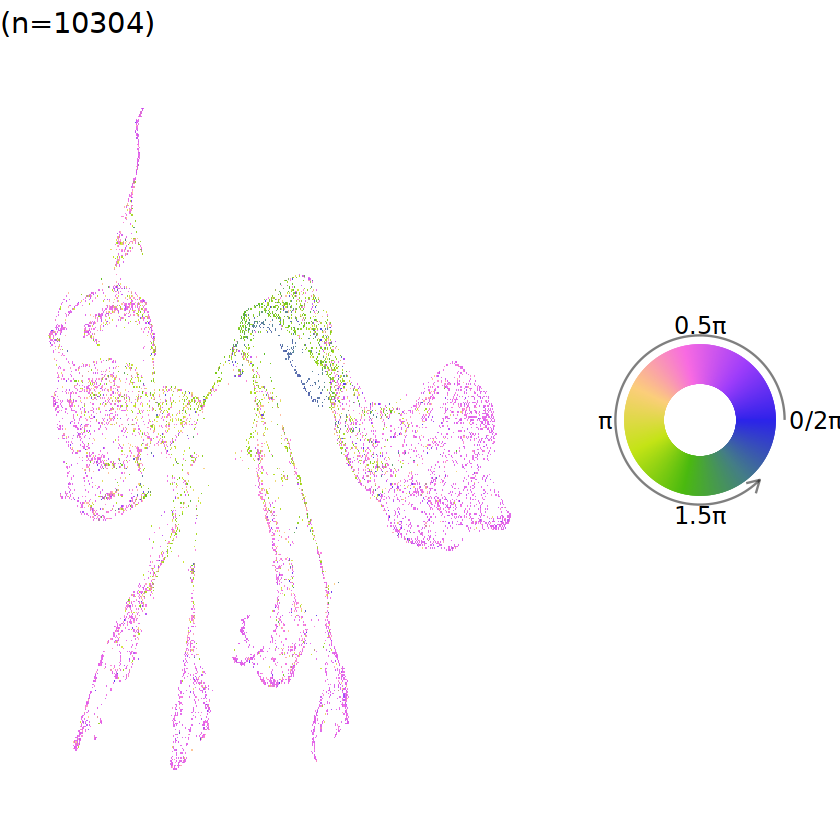

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


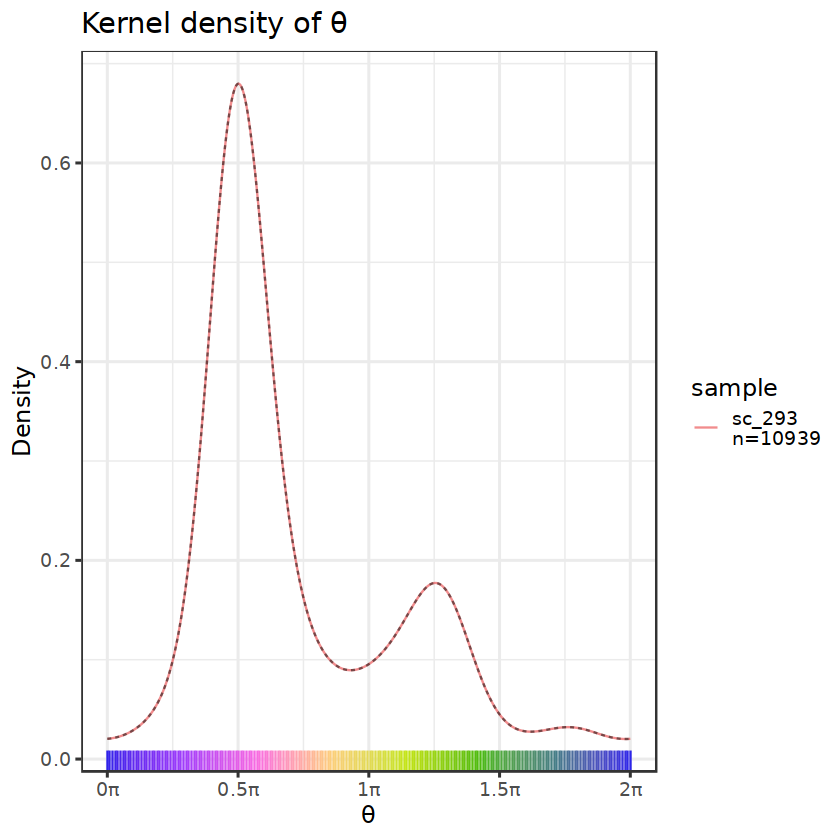

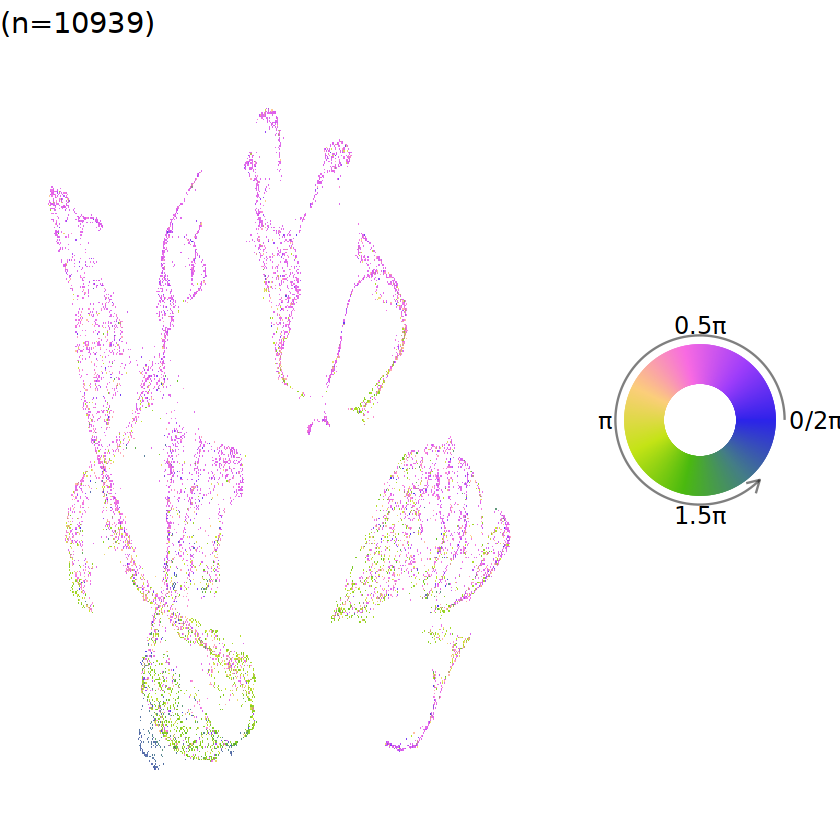

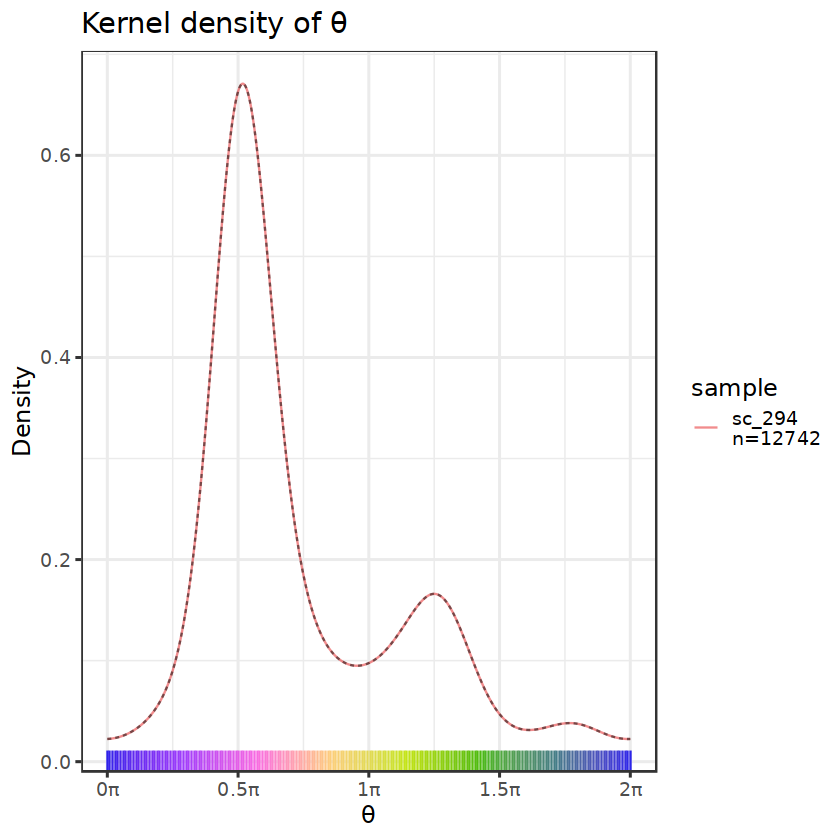

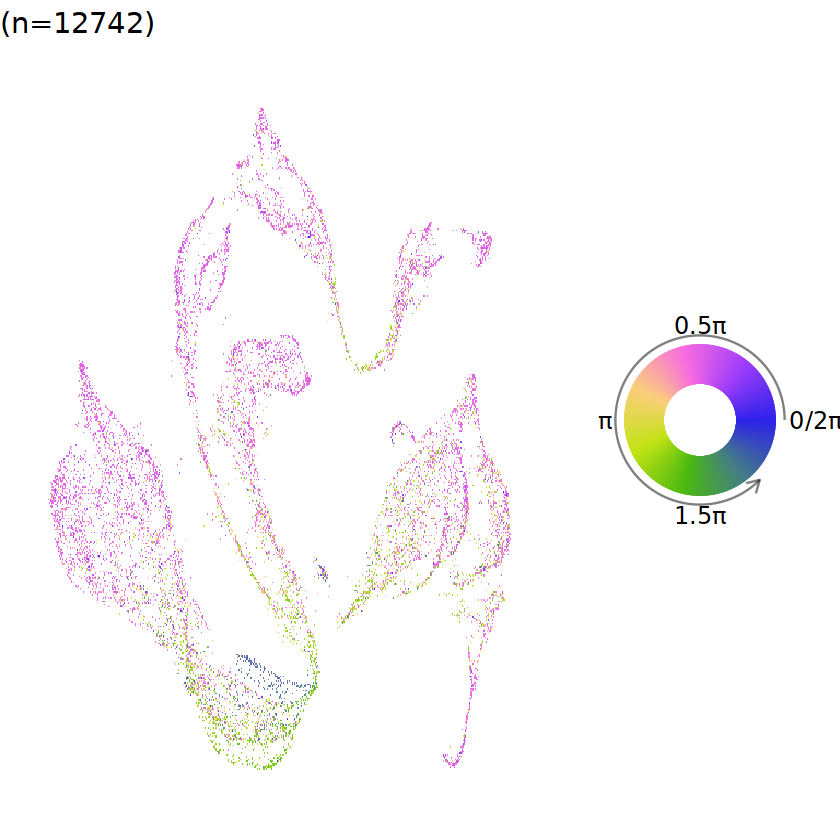

In [13]:
for (i in 1:length(sample.list)){
 run_tricycle(sample.list[i])
}

## For sample under ./scRNA-seq/Seurat_Objects/

In [6]:
run_tricycle <- function(sample){
    seu <- readRDS(paste0("./scRNA-seq/Seurat_Objects/",sample,"_COPILOT.rds"))
    sce <- as.SingleCellExperiment(seu)
    
    ## Tricycle estimation
    sce <- project_cycle_space(sce,ref.m = new.ref)
    sce <- estimate_cycle_position(sce)
    
    sce$tricyclePosition <- (sce$tricyclePosition/pi) + 1.8
    sce$tricyclePosition[which(sce$tricyclePosition>=2)] <- sce$tricyclePosition[which(sce$tricyclePosition>=2)] - 2
    sce$tricyclePosition <- sce$tricyclePosition*pi
    
    ## Plot
    print(plot_ccposition_den(sce$tricyclePosition,
                    sce$orig.ident, 'sample',
                    bw = 10, fig.title = "Kernel density of \u03b8") +
      theme_bw(base_size = 14))
    
    ## Assign position to stage
    tricycleCCStage <- sce$tricyclePosition/pi

    G1_idx <- which(tricycleCCStage < 1 & tricycleCCStage >= 0)
    S_idx <- which(tricycleCCStage >= 1 & tricycleCCStage < 1.55)
    G2_idx <- which(tricycleCCStage >= 1.55 & tricycleCCStage <= 2)
                    
    tricycleCCStage[G1_idx]="G1/G0"
    tricycleCCStage[S_idx]="S"
    tricycleCCStage[G2_idx]="G2M"
    
    sce$tricycleCCStage <- tricycleCCStage
    
    ## Schwabe Stage
    #sce <- estimate_Schwabe_stage(sce,cycleGene.l = cc.gene.list)
    
    ## Table
    #seu$time.anno.Li <- gsub("_.*$","",seu$time.celltype.anno.Li)
    #print(table(seu$time.anno.Li, sce$tricycleCCStage))
    
    ## Prepare seu
    #seu <- prep(seu)
    #plot_anno(seu)
    
    ## Sce to seu
    seu$tricyclePosition <- sce$tricyclePosition/pi
    seu$tricycleCCStage <- sce$tricycleCCStage
    #seu$SchwabeCCStage <- sce$CCStage
    
    ## Tricycle position on umap
    p <- plot_emb_circle_scale(sce, dimred = "UMAP",
                           point.size = 1, point.alpha = 0.9) +
      theme_void(base_size = 14)
    legend <- circle_scale_legend(text.size = 5, alpha = 0.9)
    print(plot_grid(p, legend, ncol = 2, rel_widths = c(1, 0.5)))
    
    ## Write annotations as csv
    write.csv(seu@meta.data[,c("tricyclePosition", "tricycleCCStage")], paste0("./tricycle/",sample,".csv"), quote=FALSE)
    #saveRDS(seu,paste0("./scRNA-seq/Seurat_Objects/",sample,"_COPILOT_seu4.rds"))
}

In [7]:
sample.list <- c("sc_155","sc_156","sc_157","sc_158","sc_159","sc_160","sc_161","sc_162","sc_163","sc_164","sc_165","sc_166","sc_167","sc_168","sc_169","sc_170","sc_171","sc_172","sc_173","sc_174","sc_175","sc_176","sc_177","sc_178","sc_179","sc_180")

The number of projection genes found in the new data is 244.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


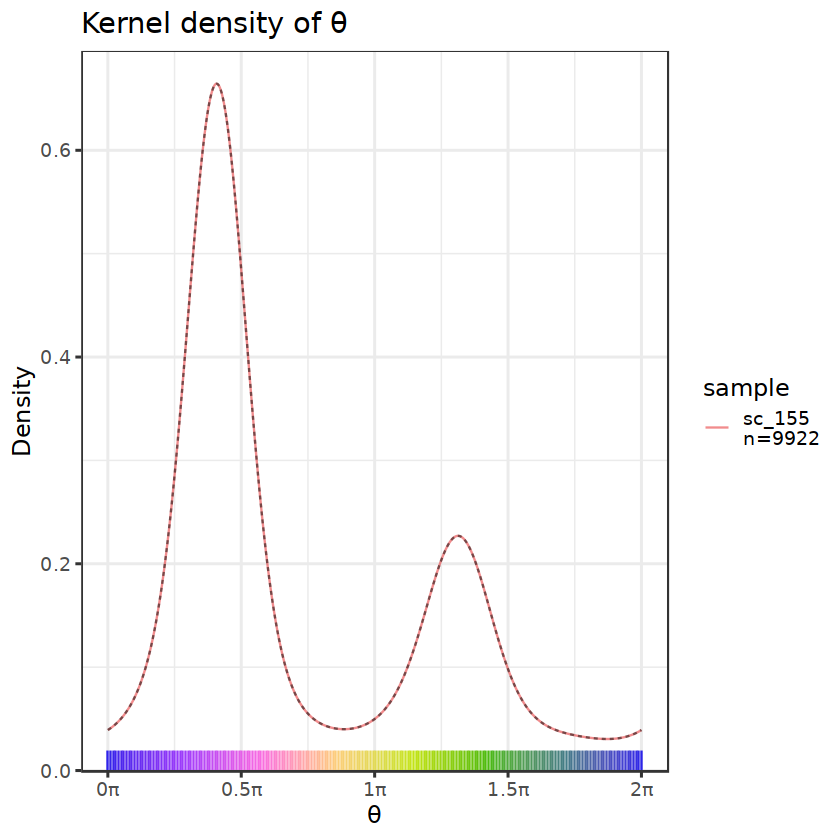

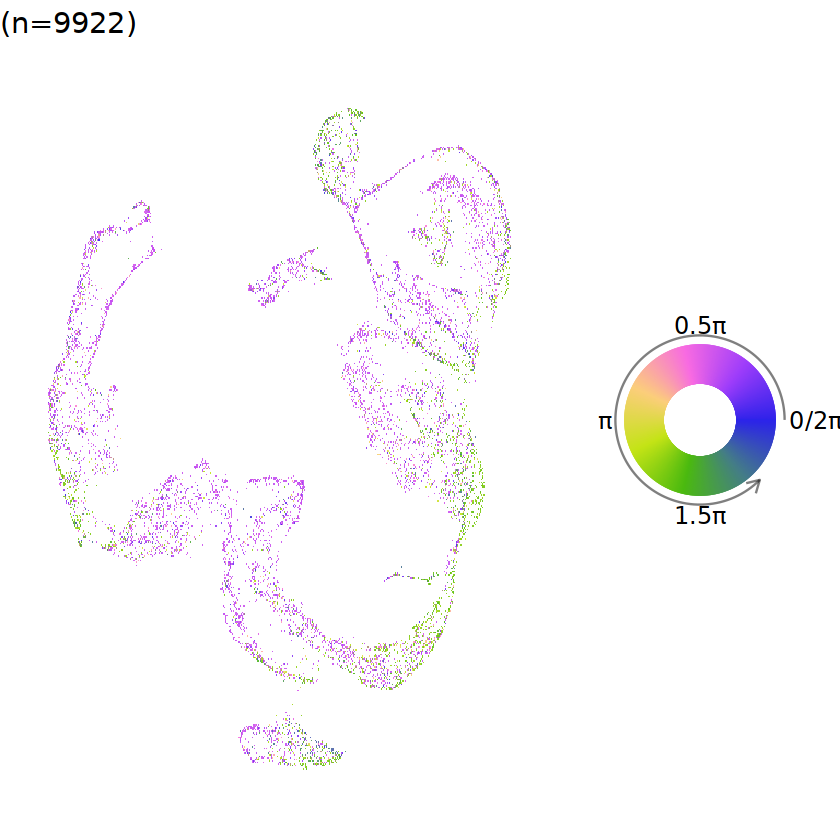

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


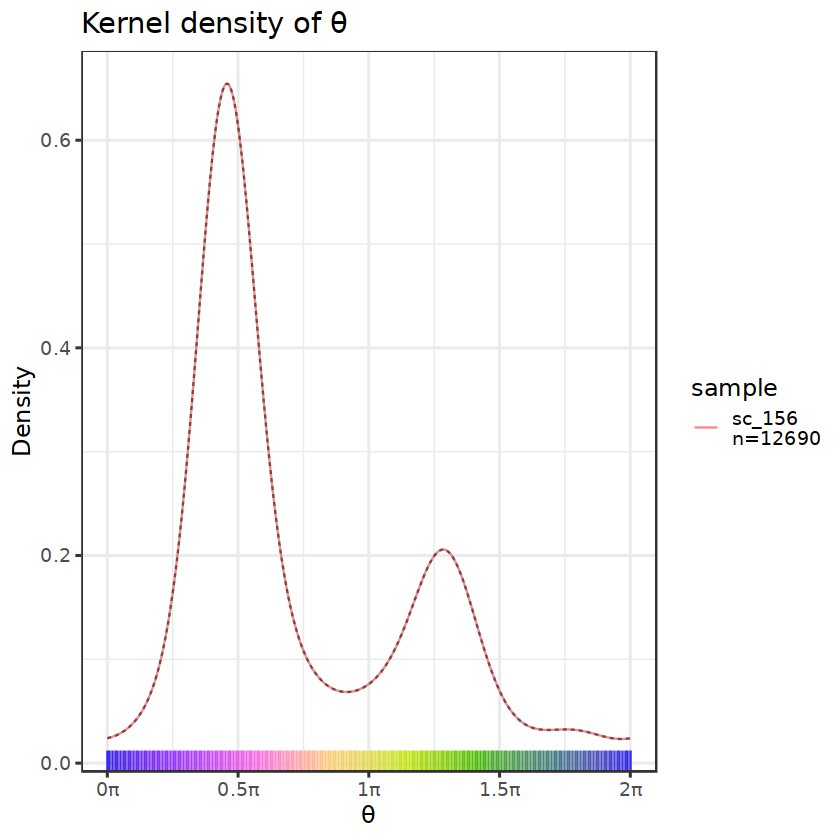

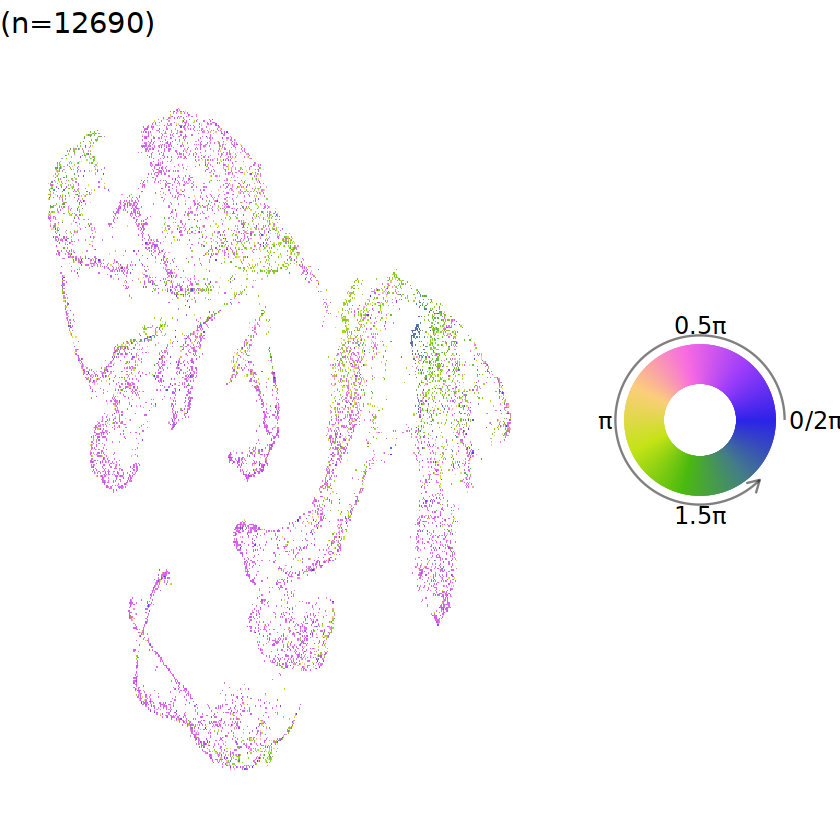

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


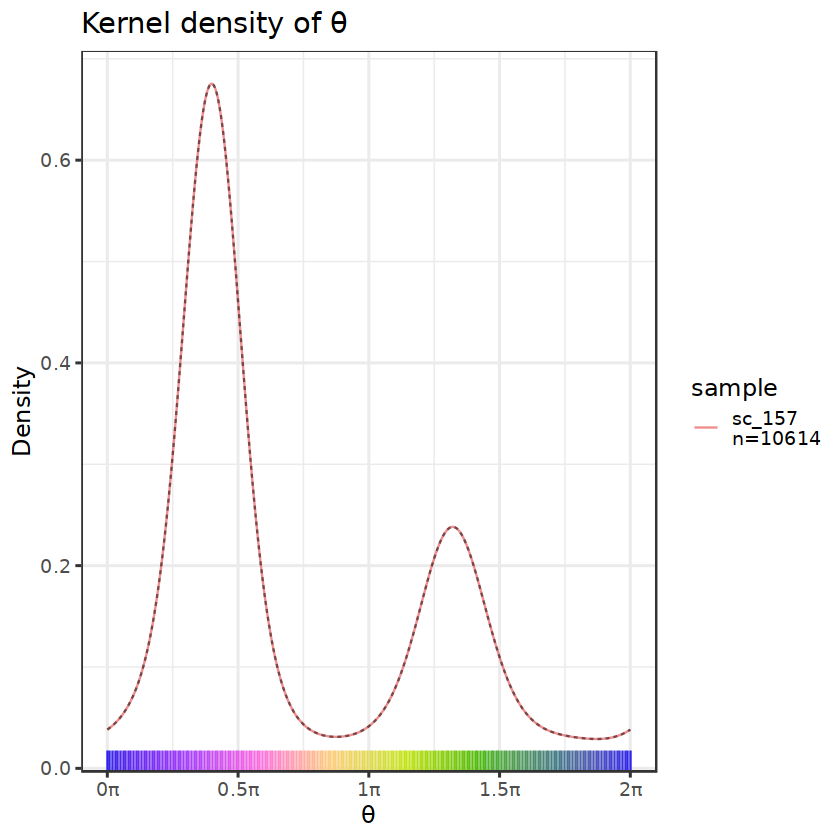

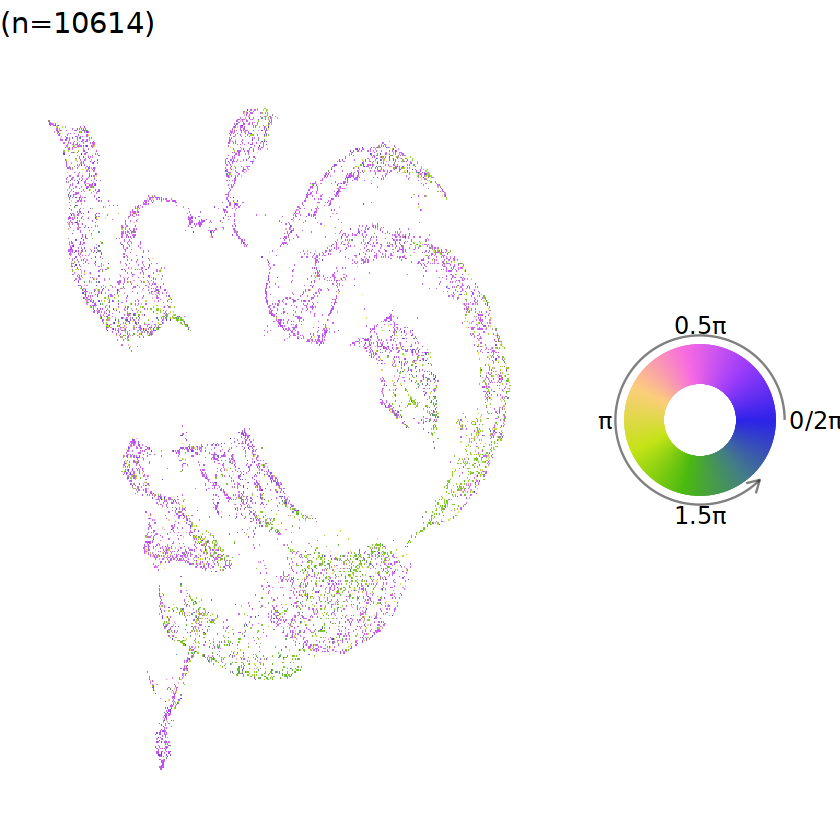

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


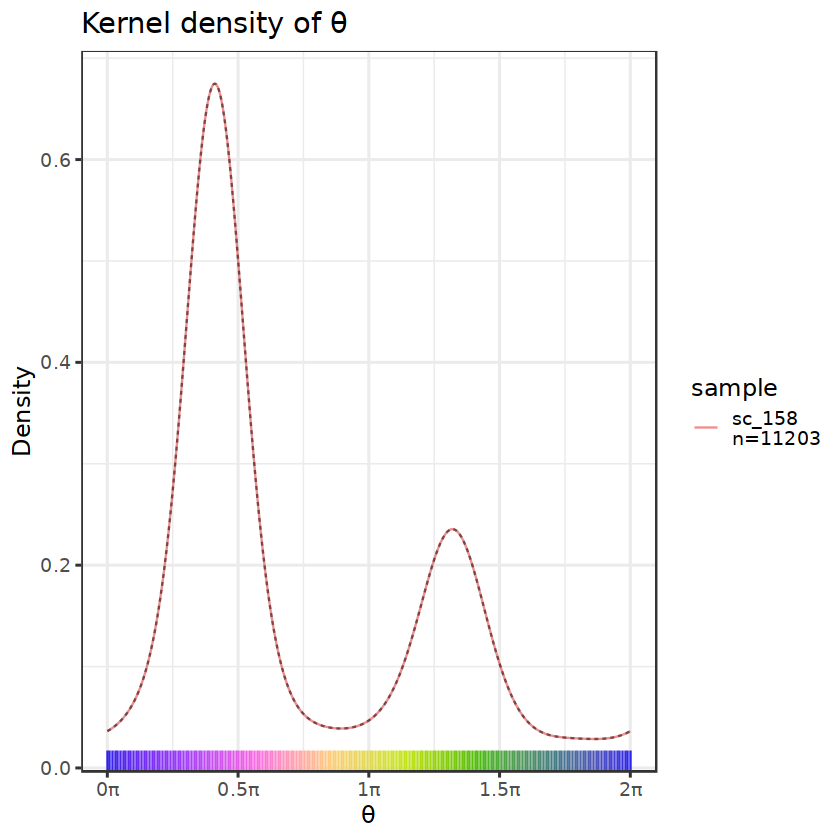

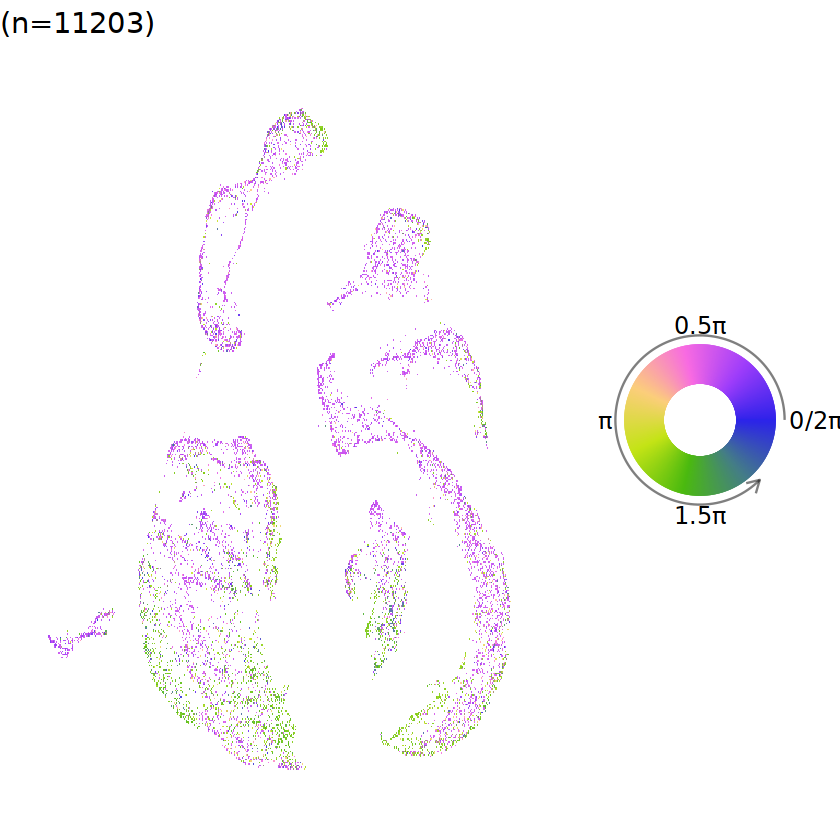

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


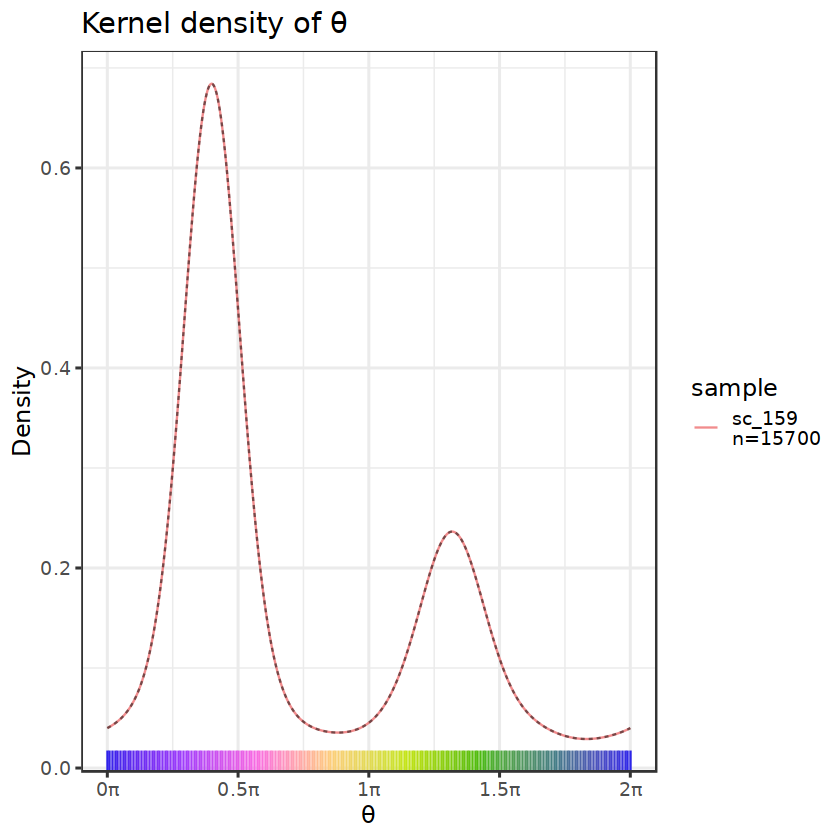

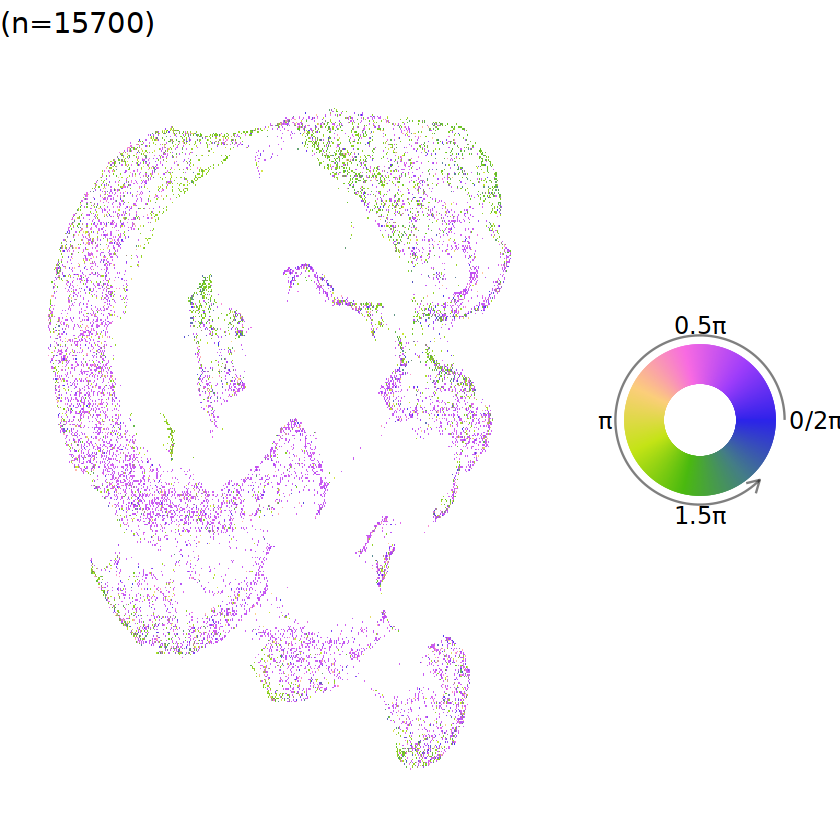

The number of projection genes found in the new data is 240.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


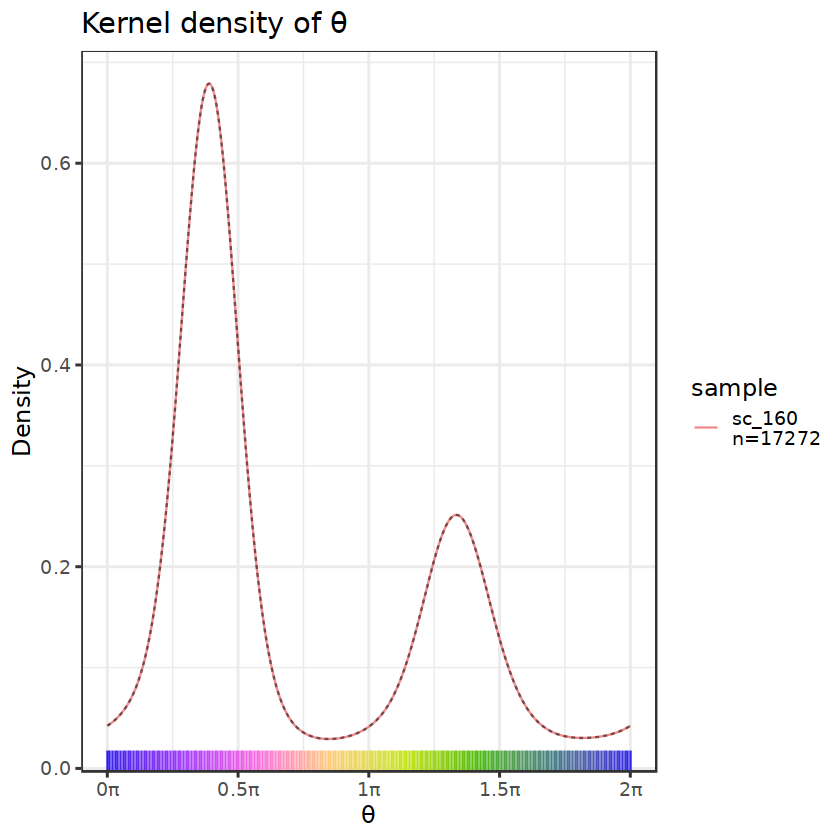

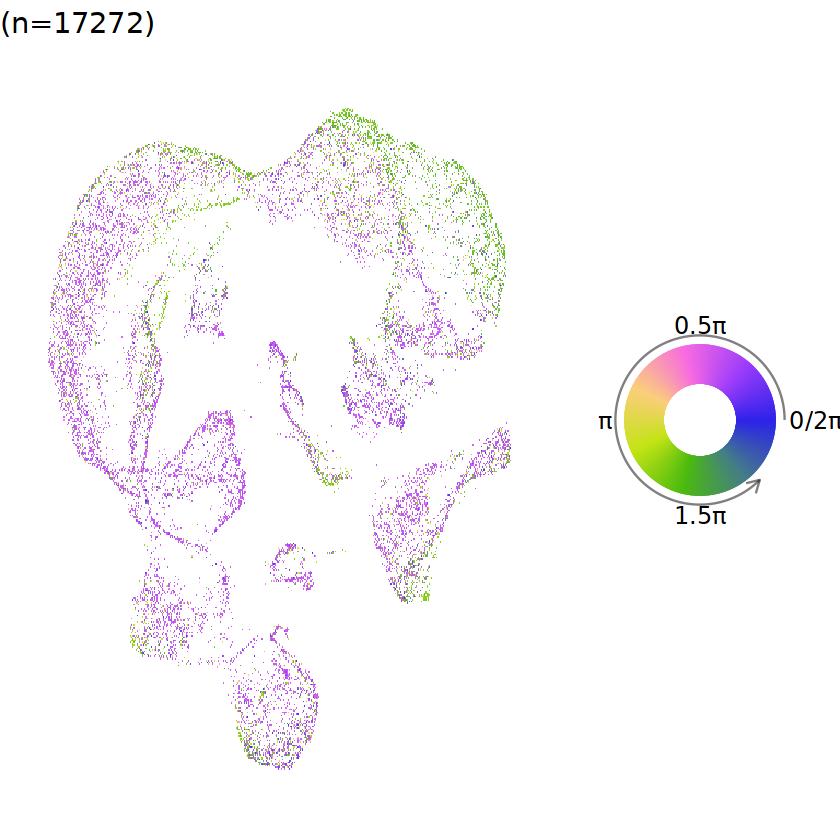

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


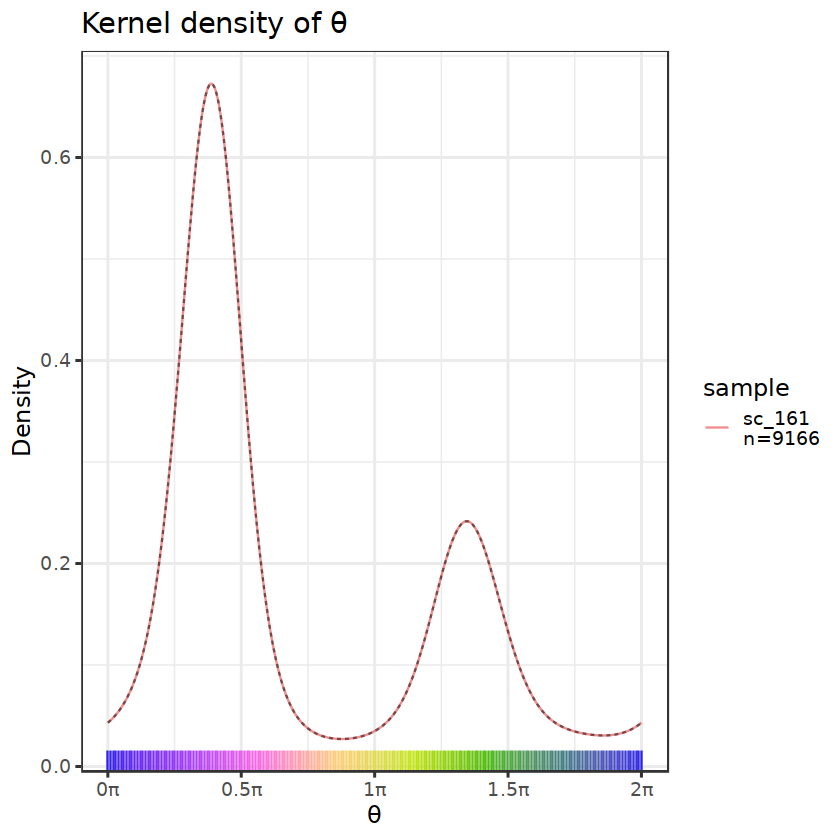

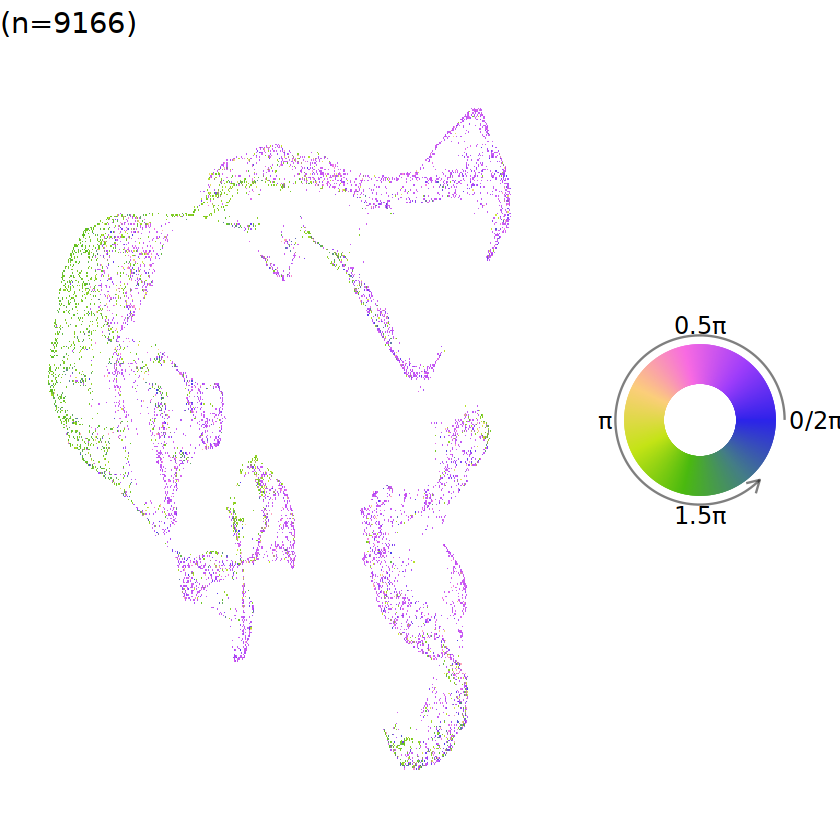

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


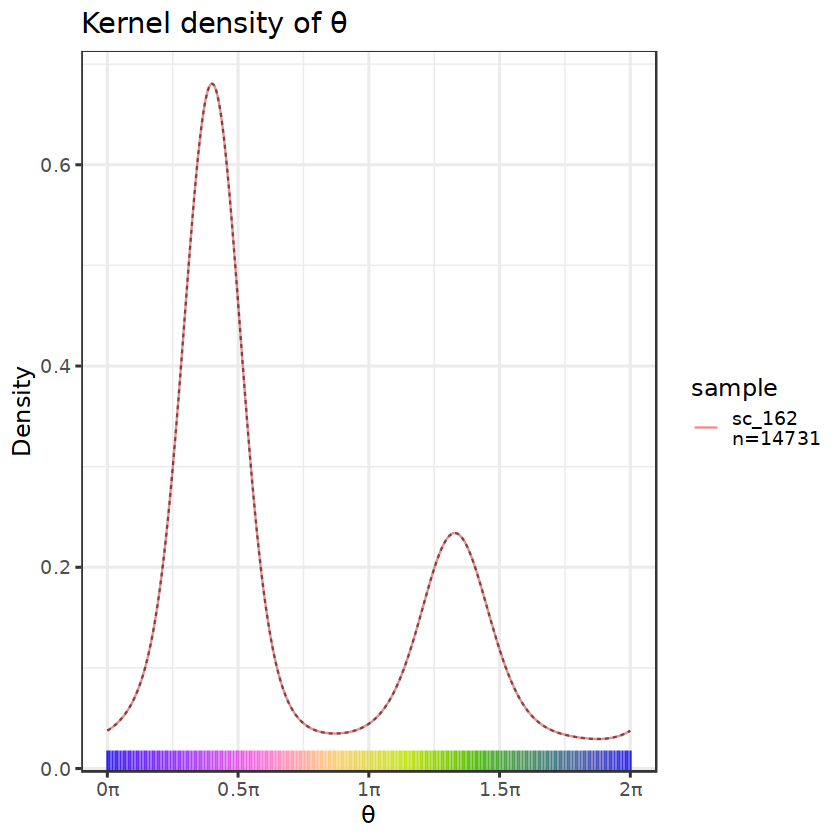

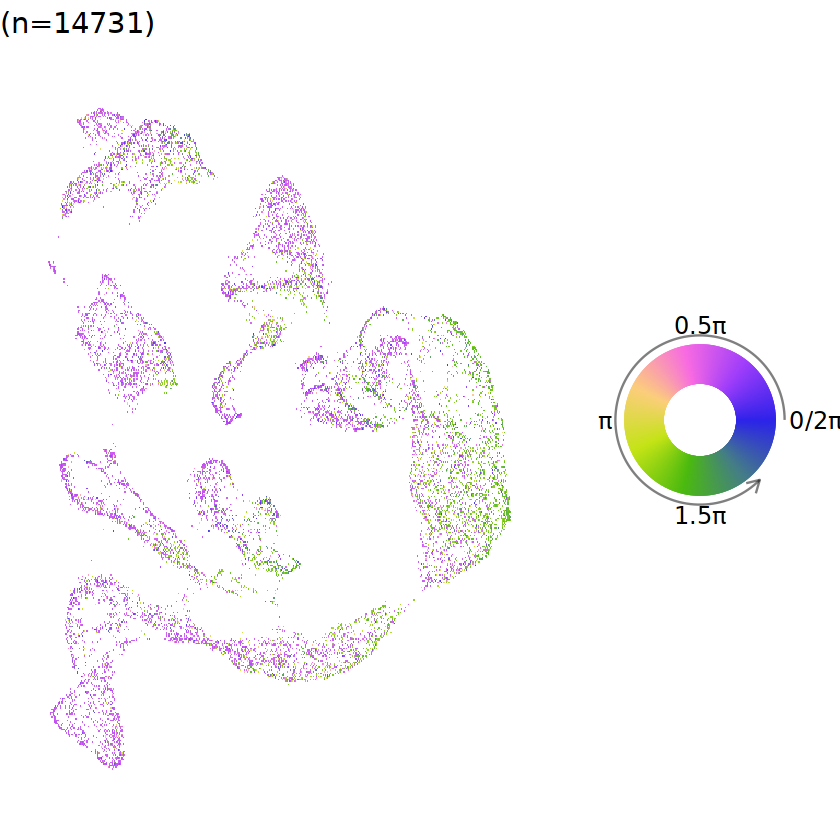

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


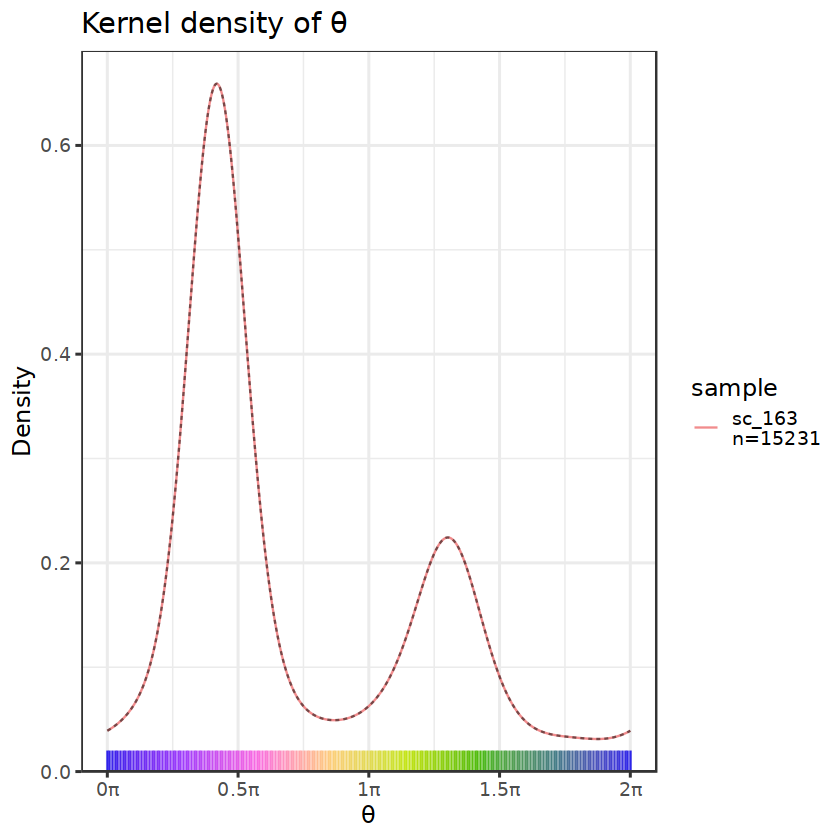

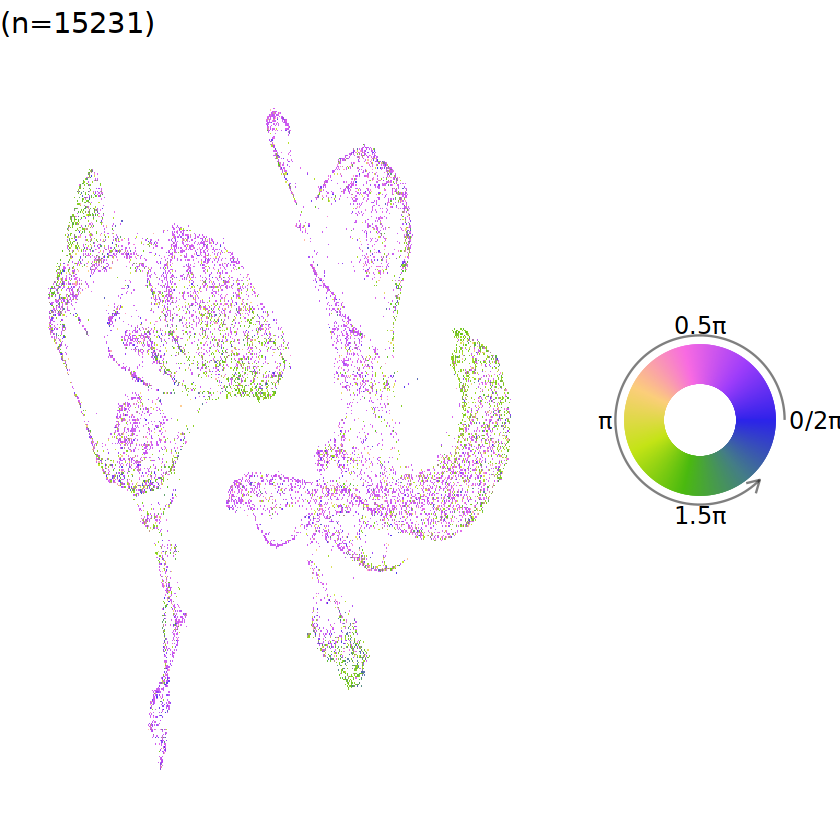

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


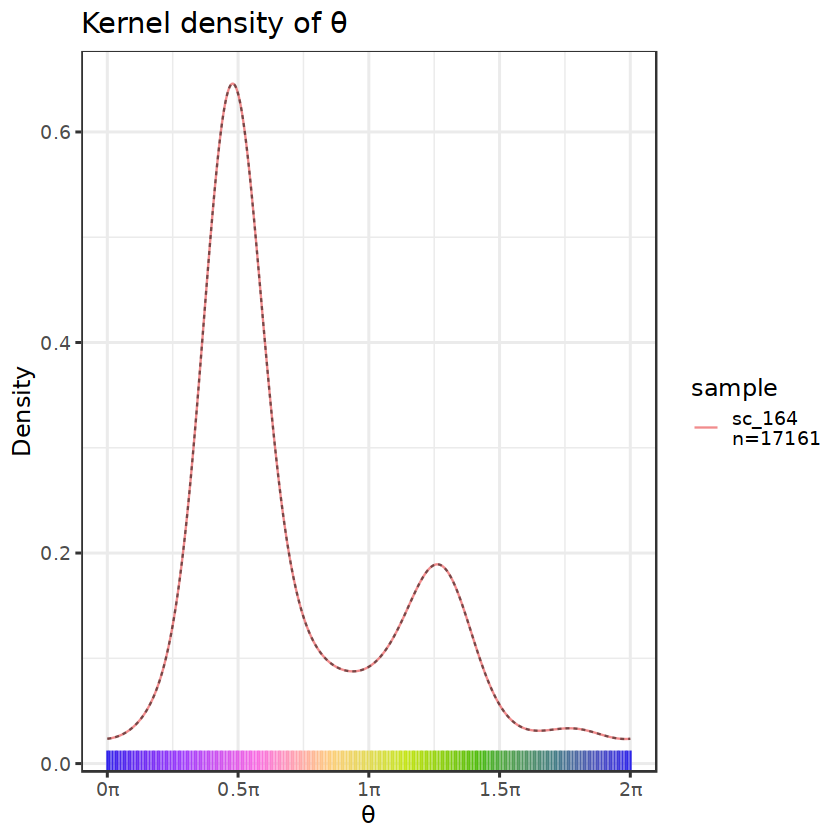

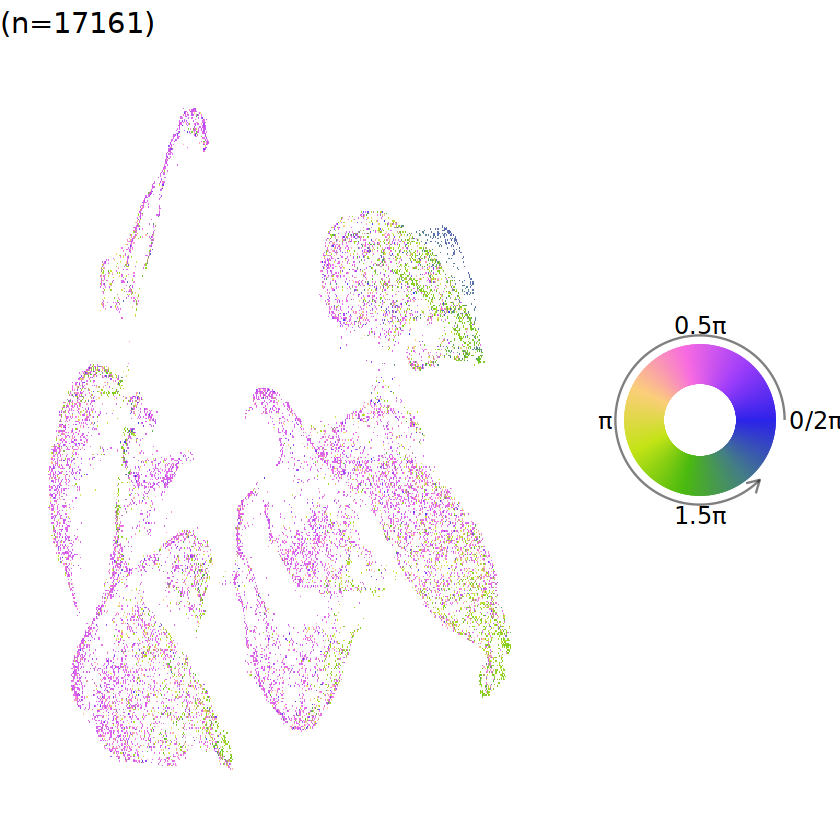

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


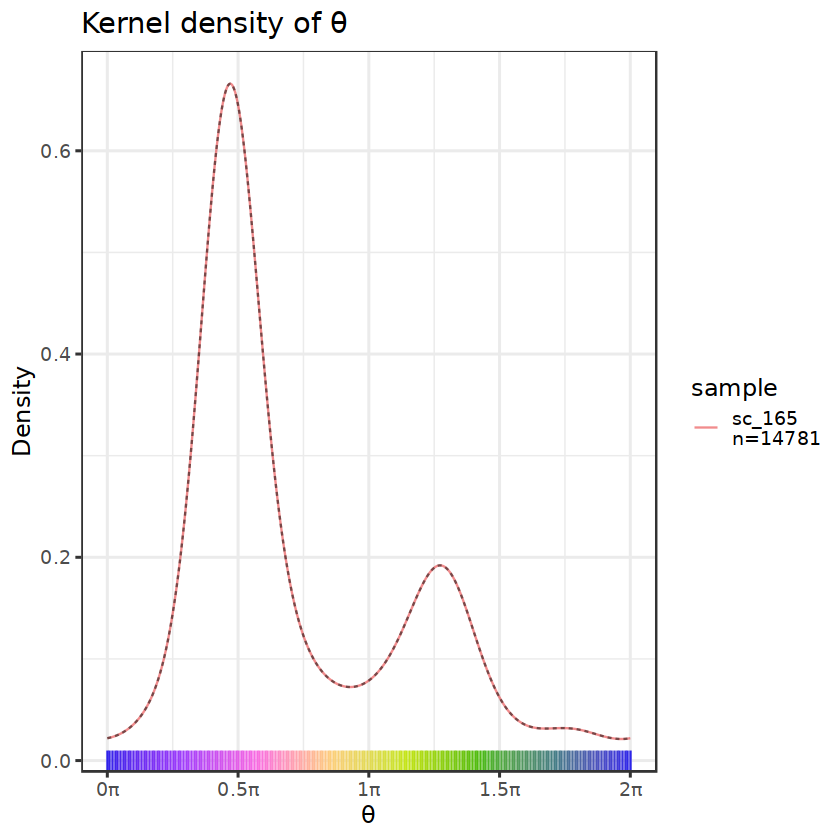

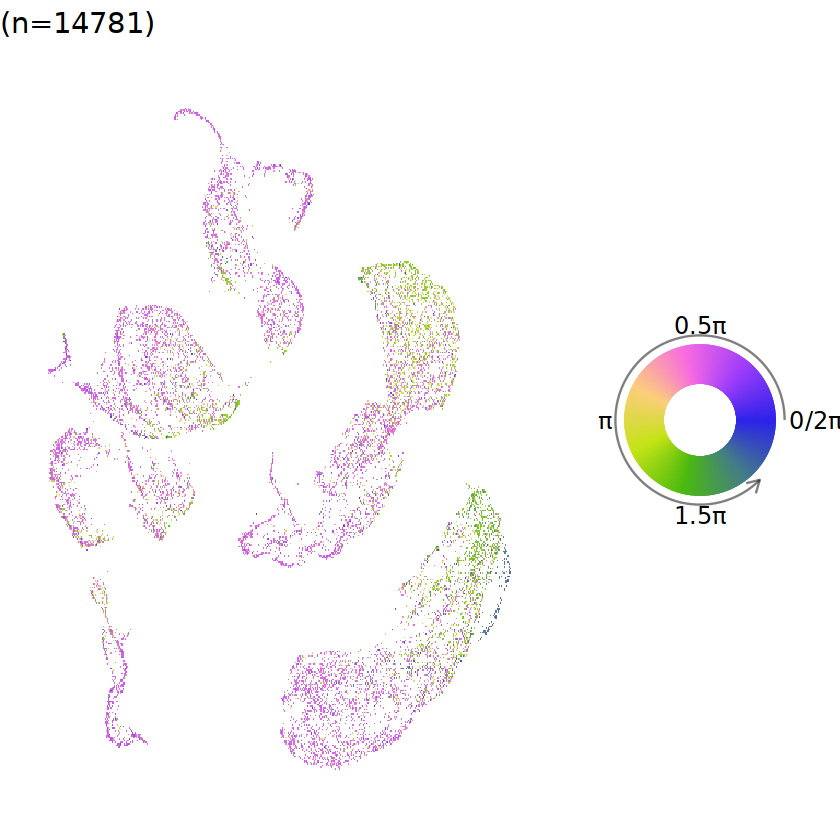

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


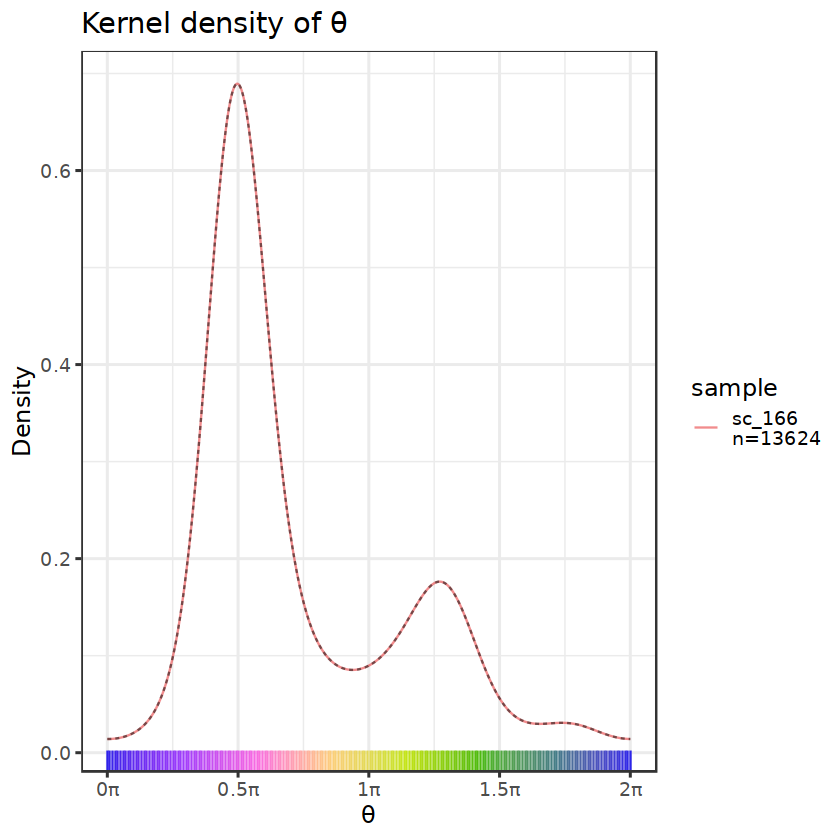

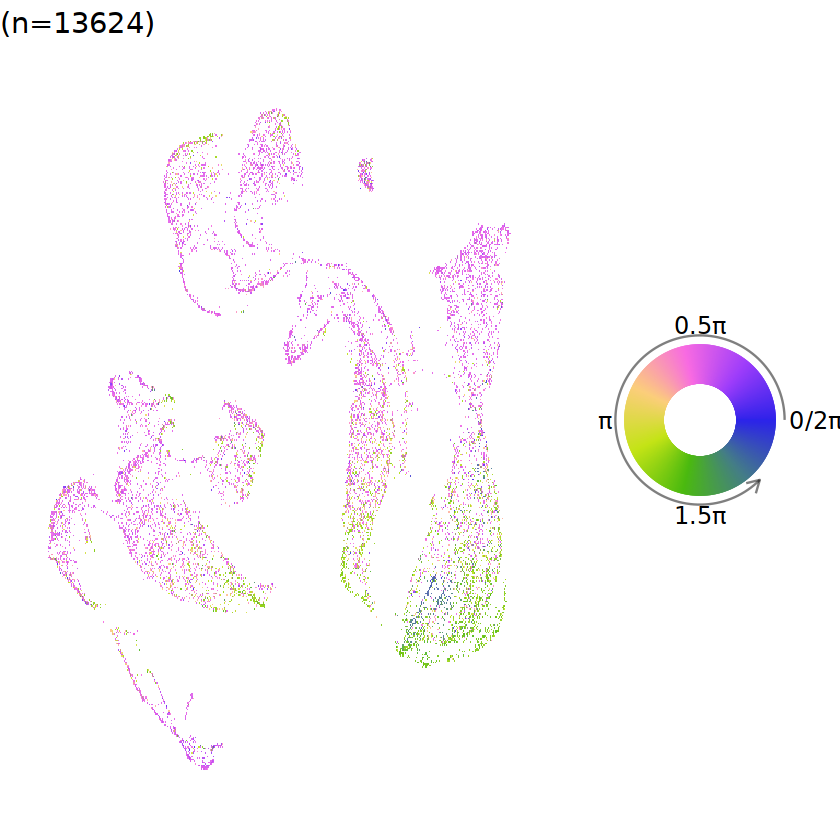

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


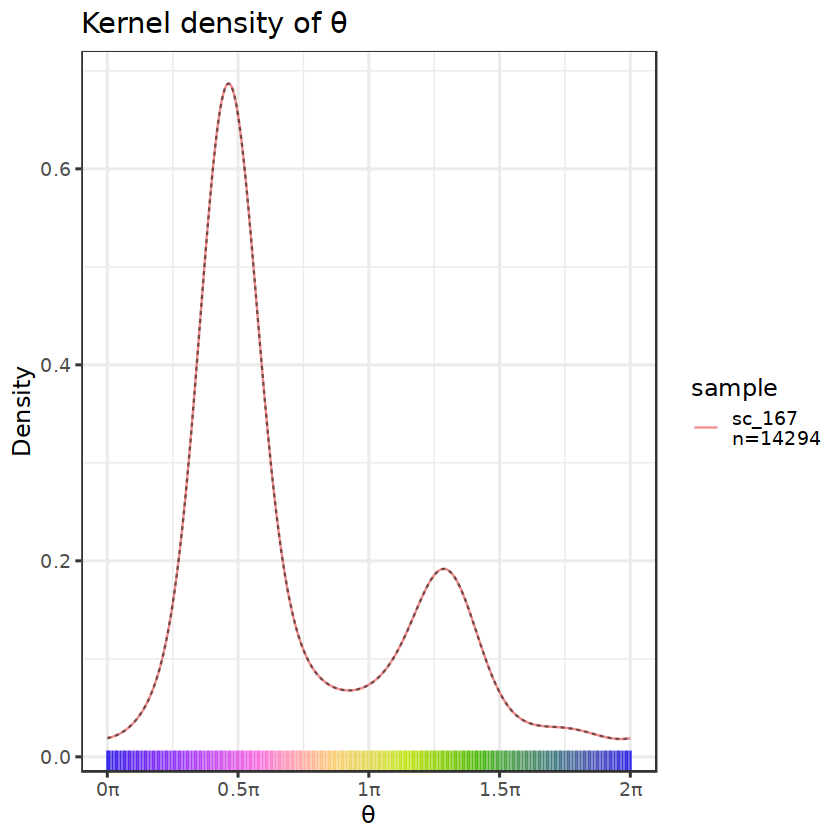

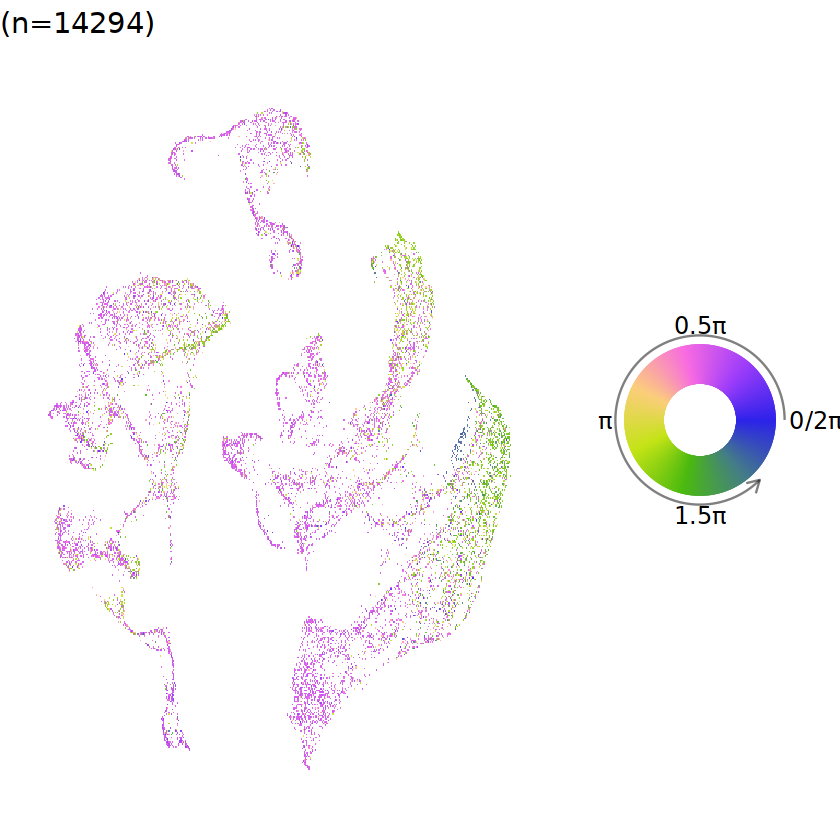

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


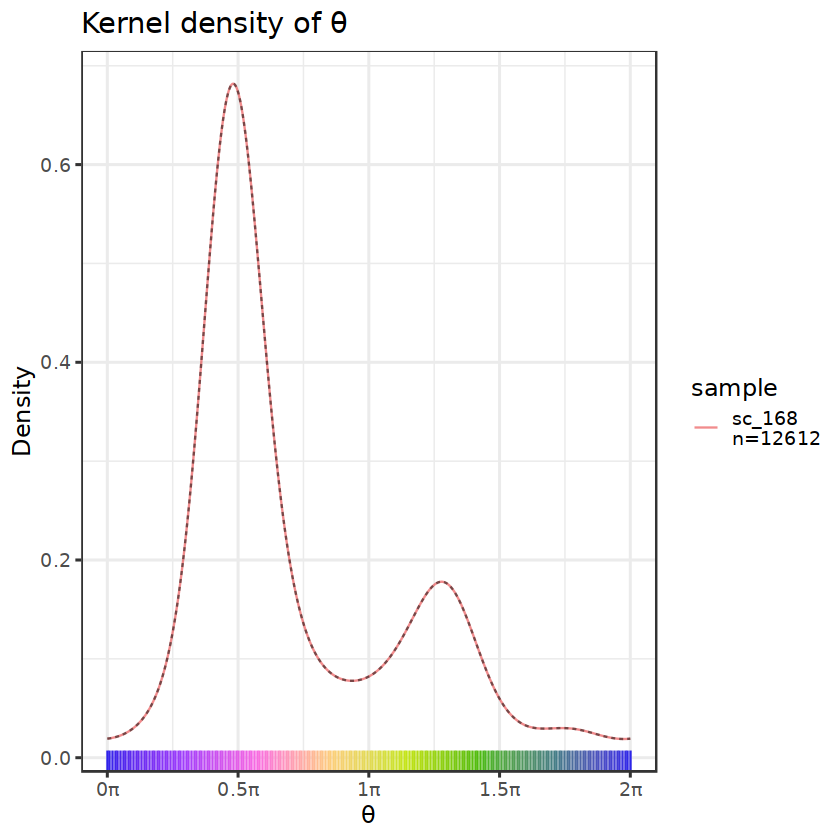

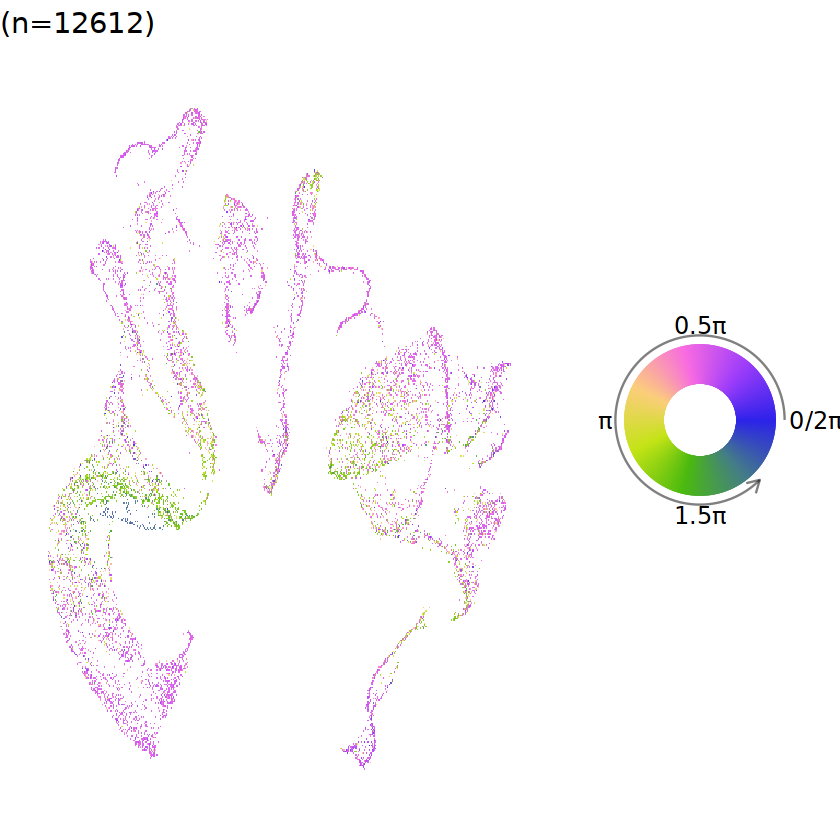

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


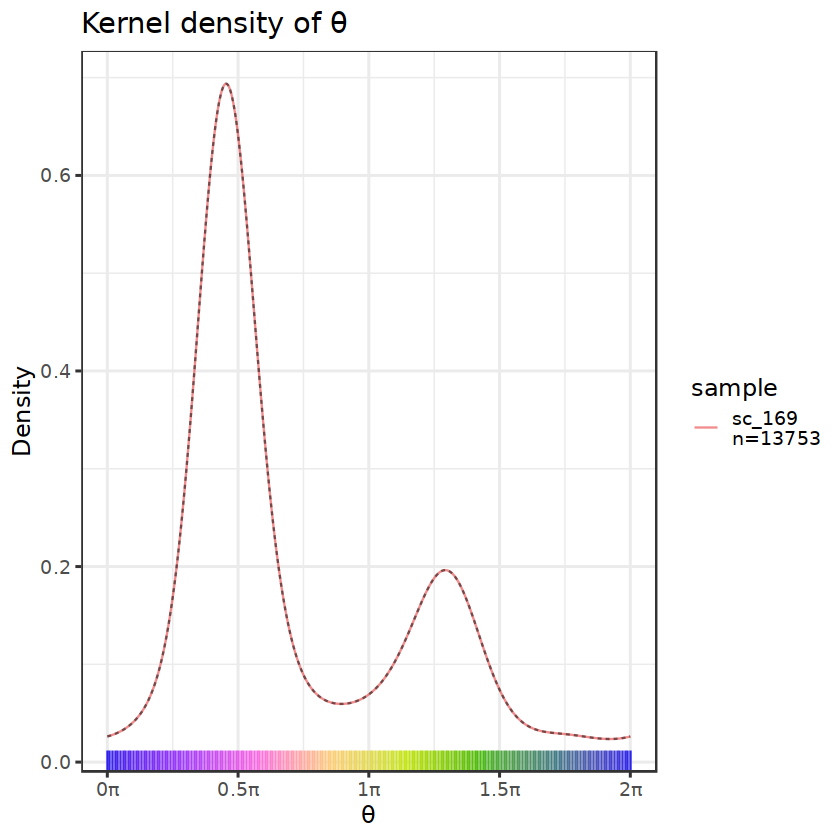

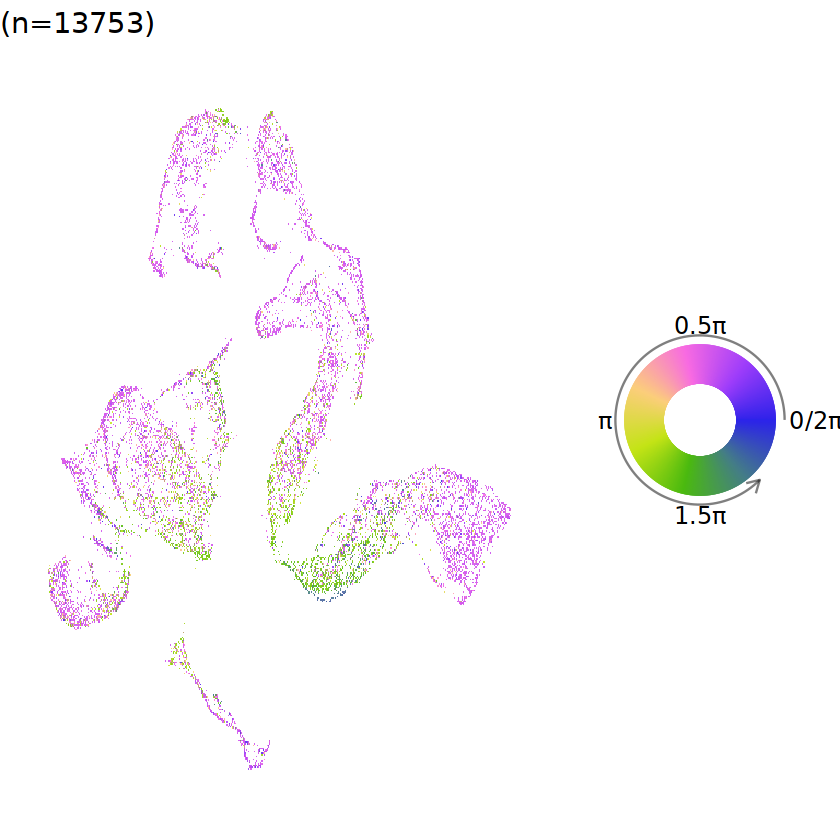

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


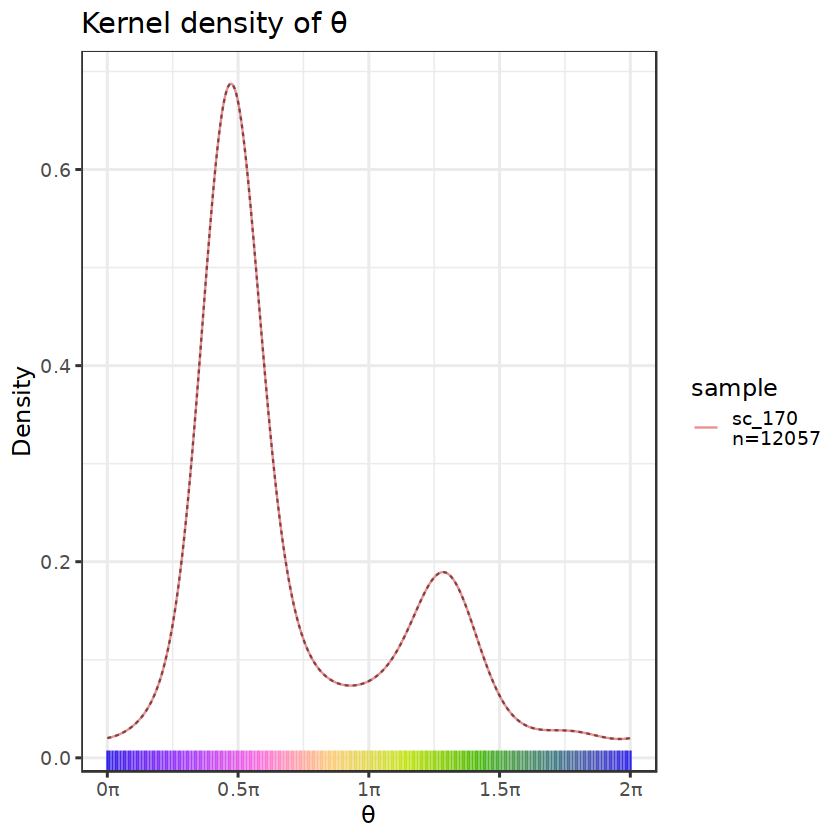

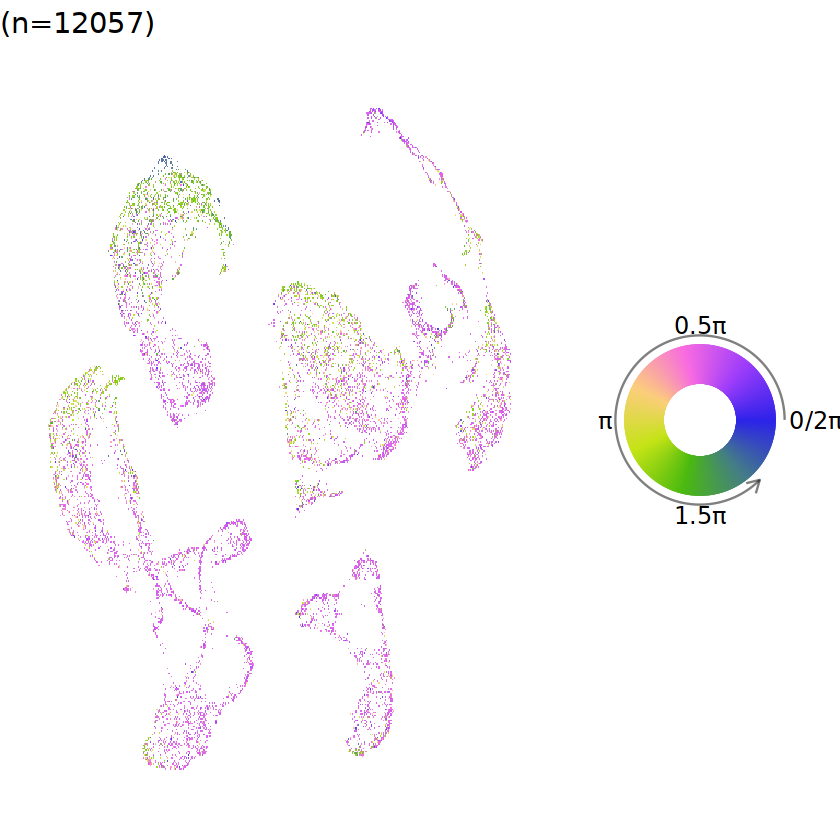

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


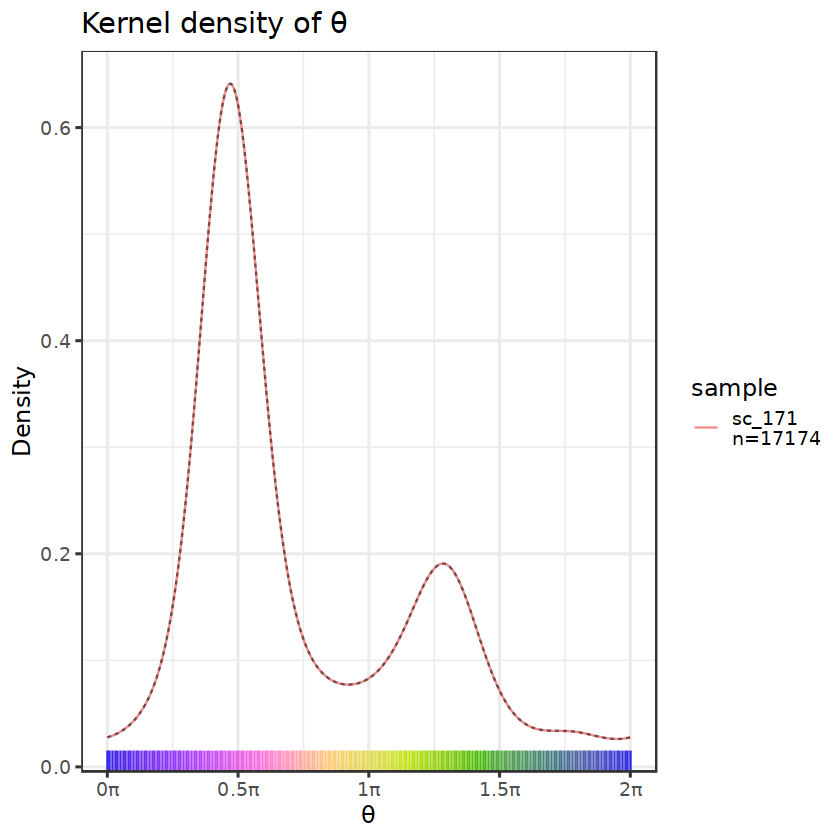

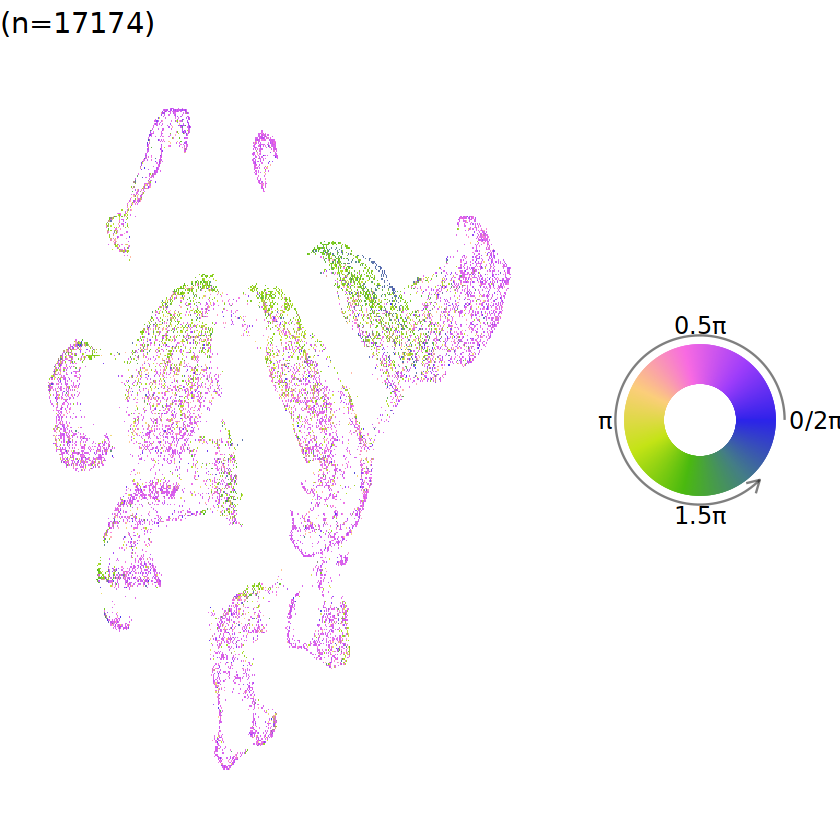

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


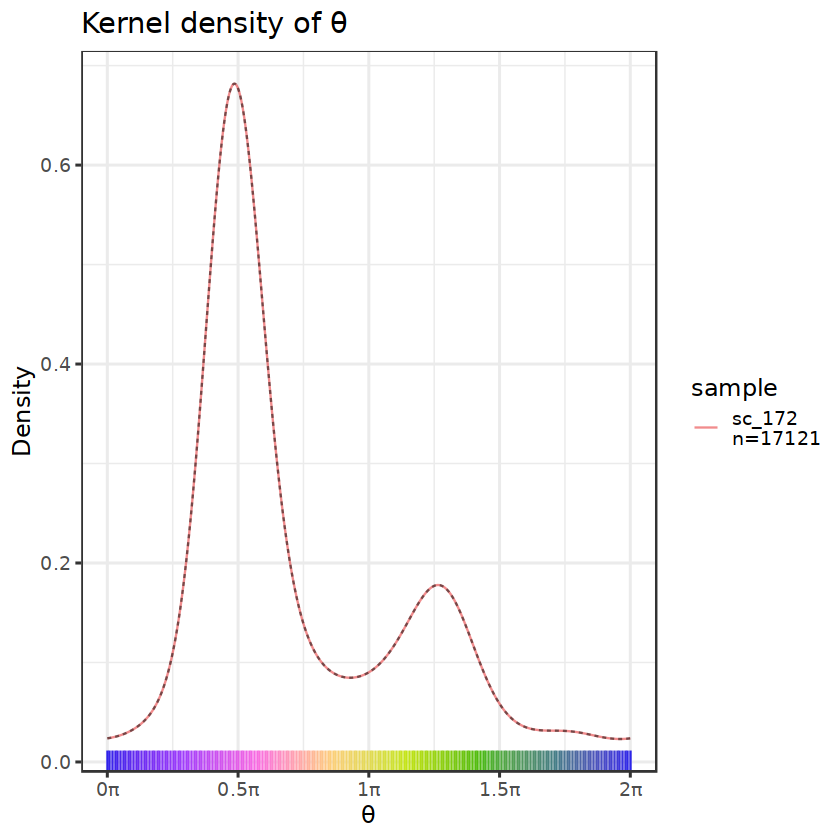

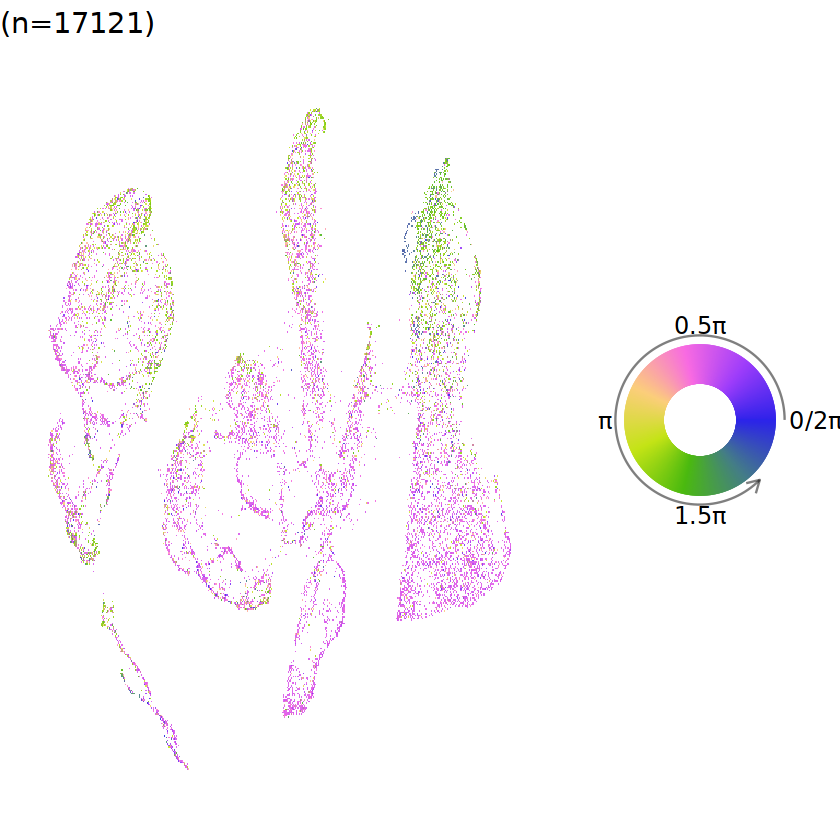

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


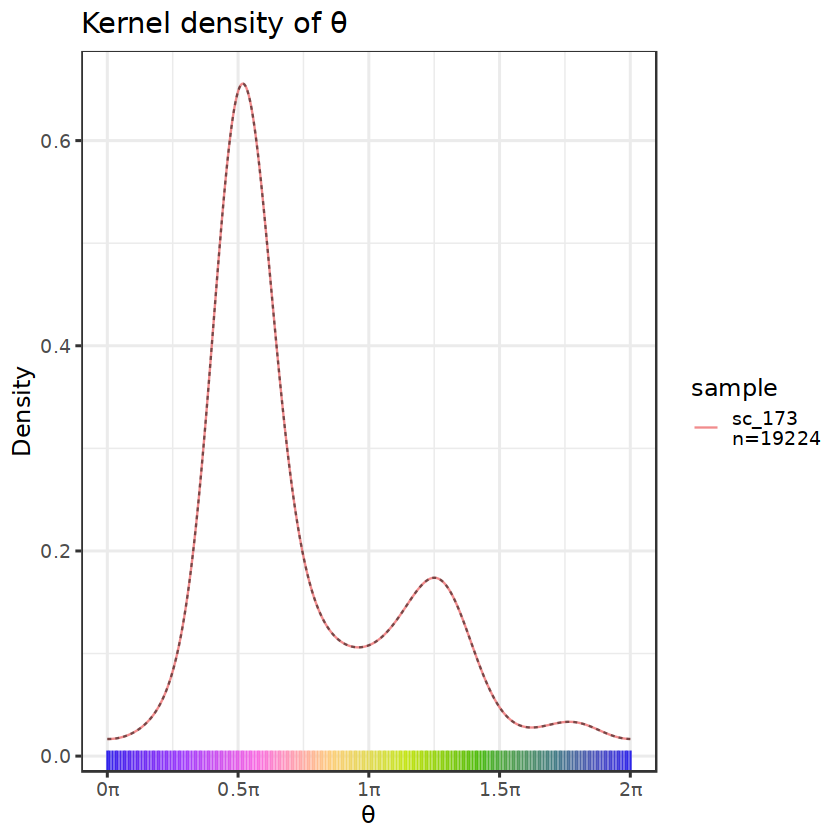

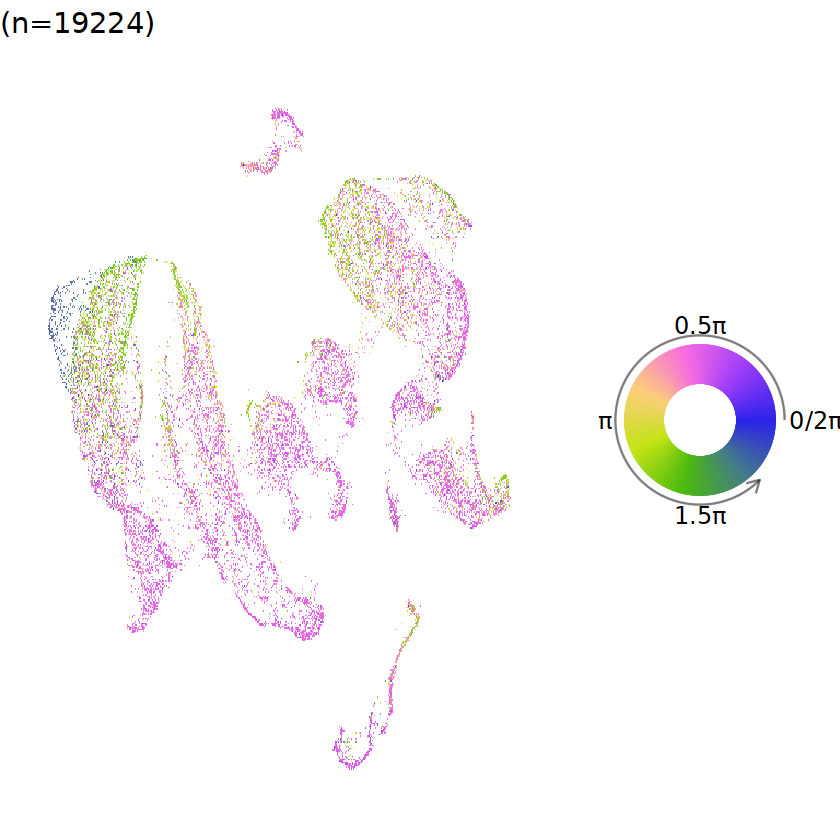

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


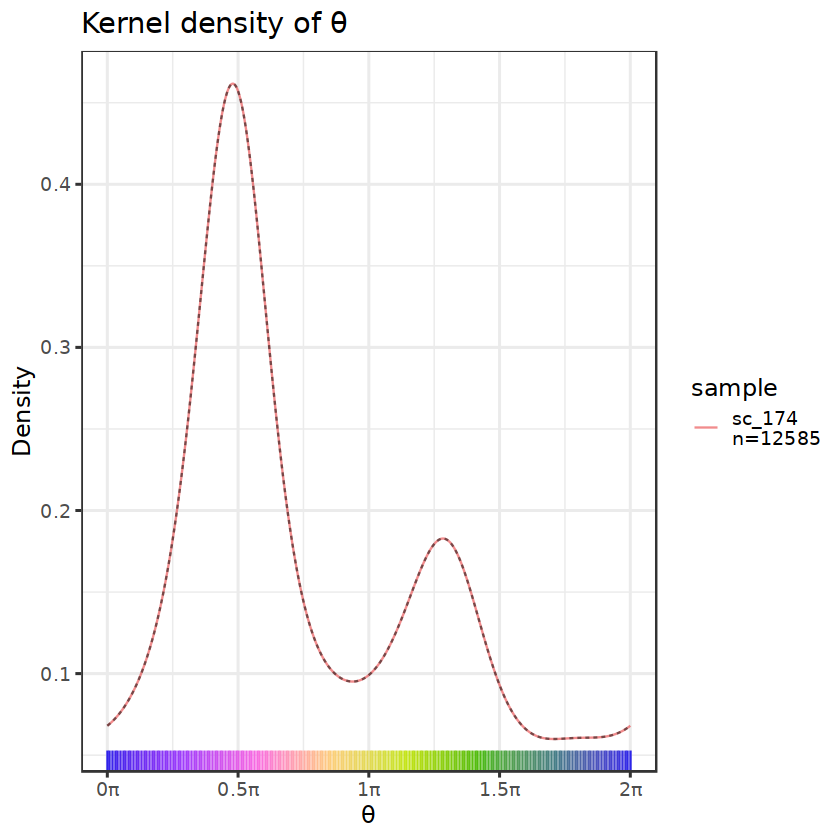

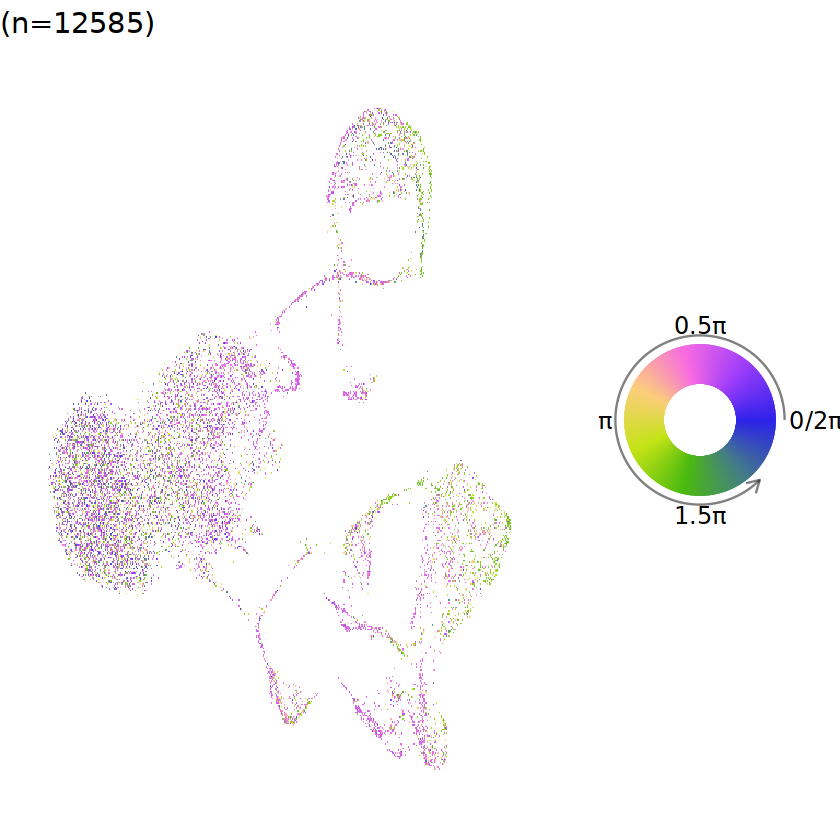

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


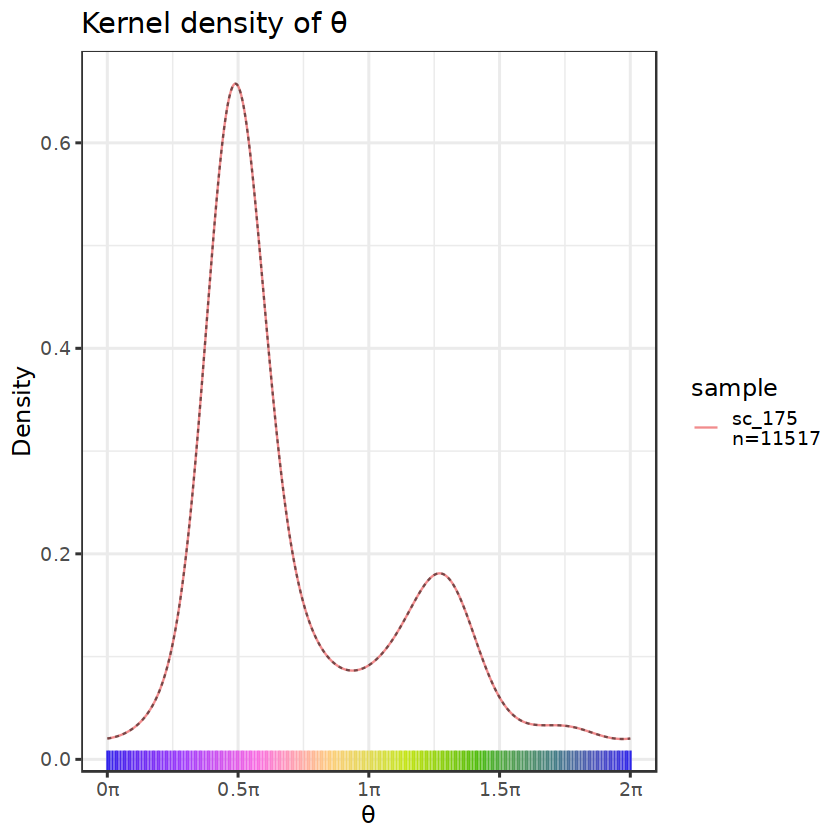

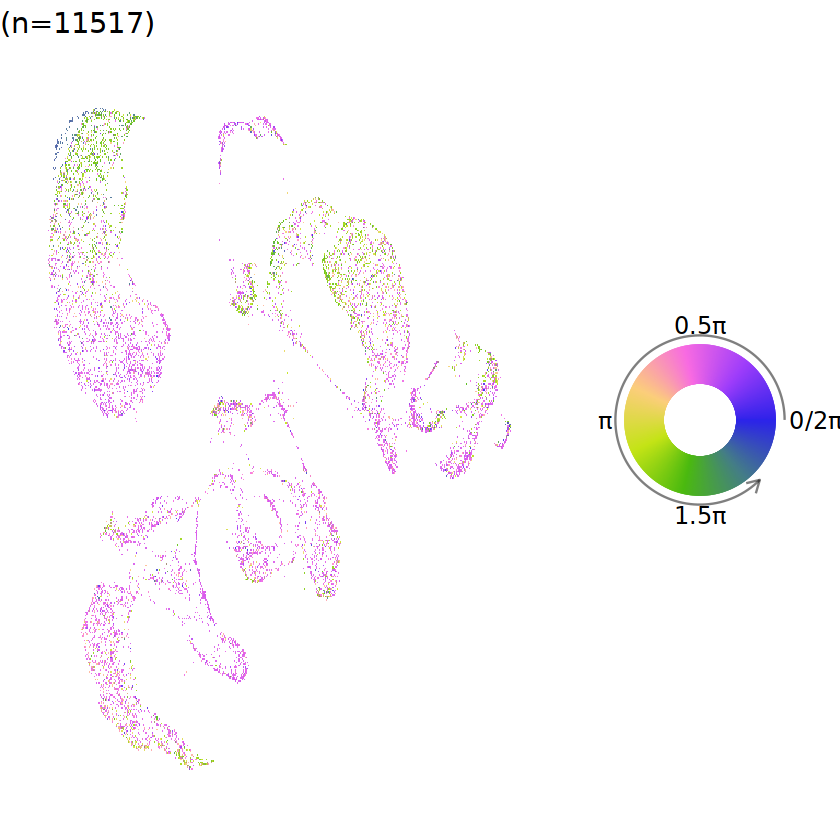

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


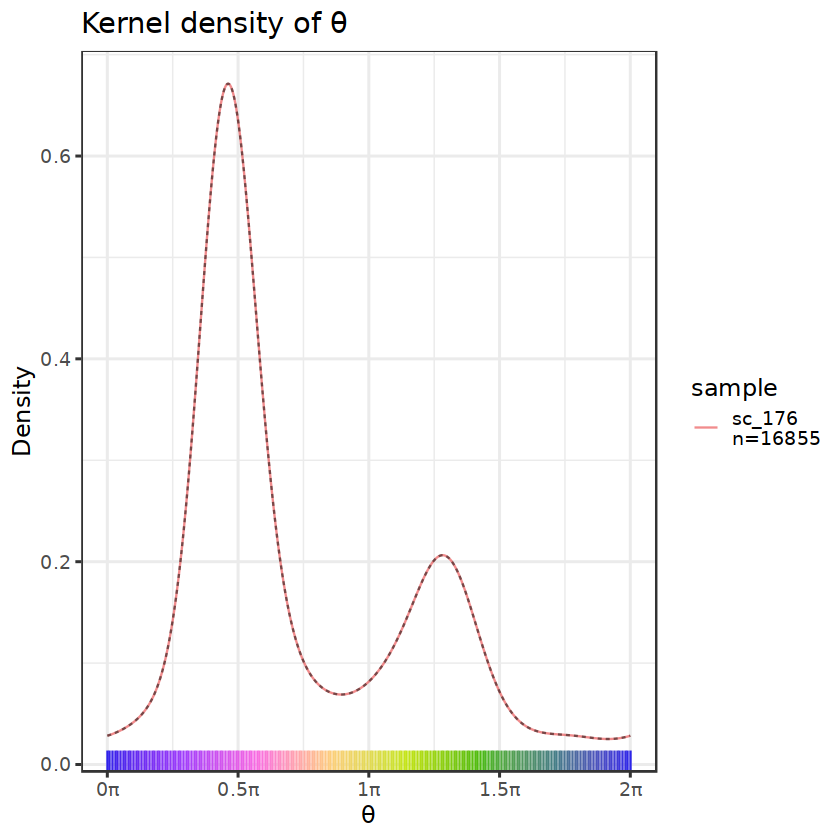

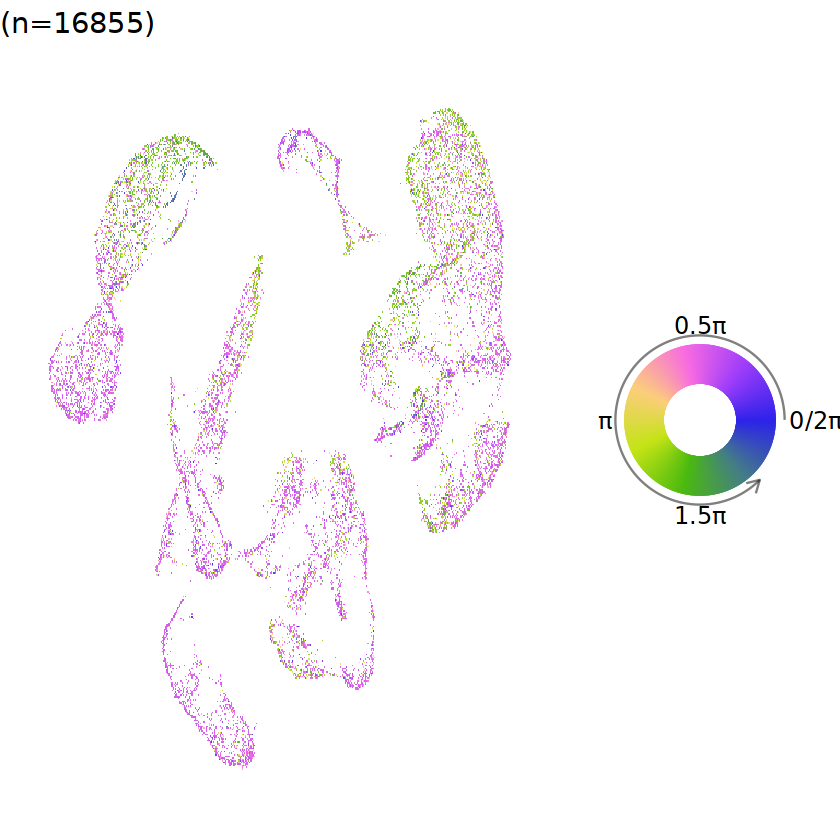

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


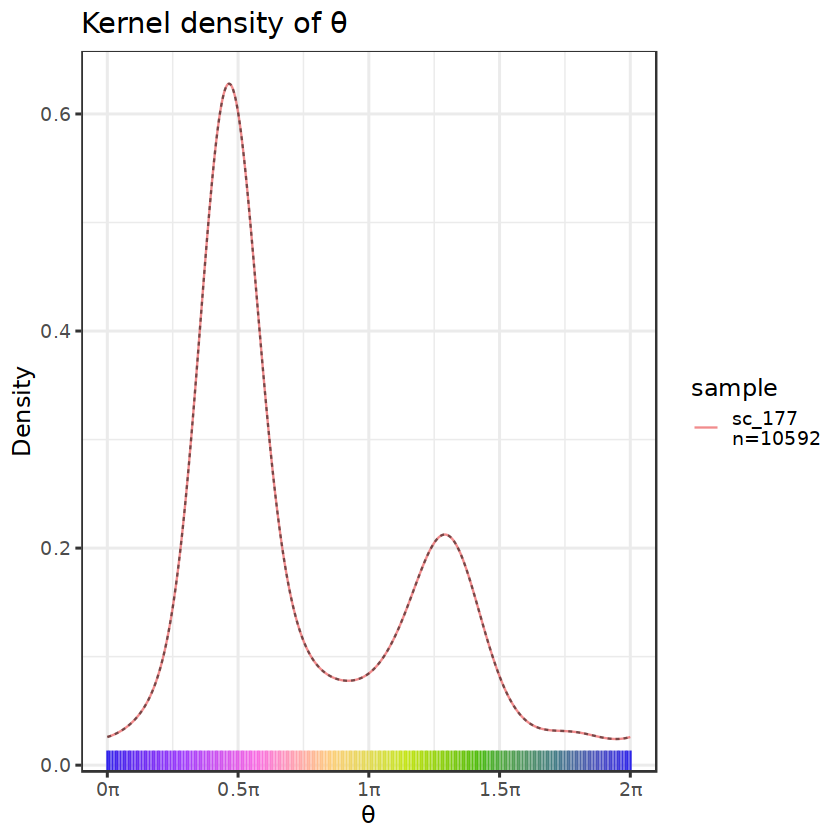

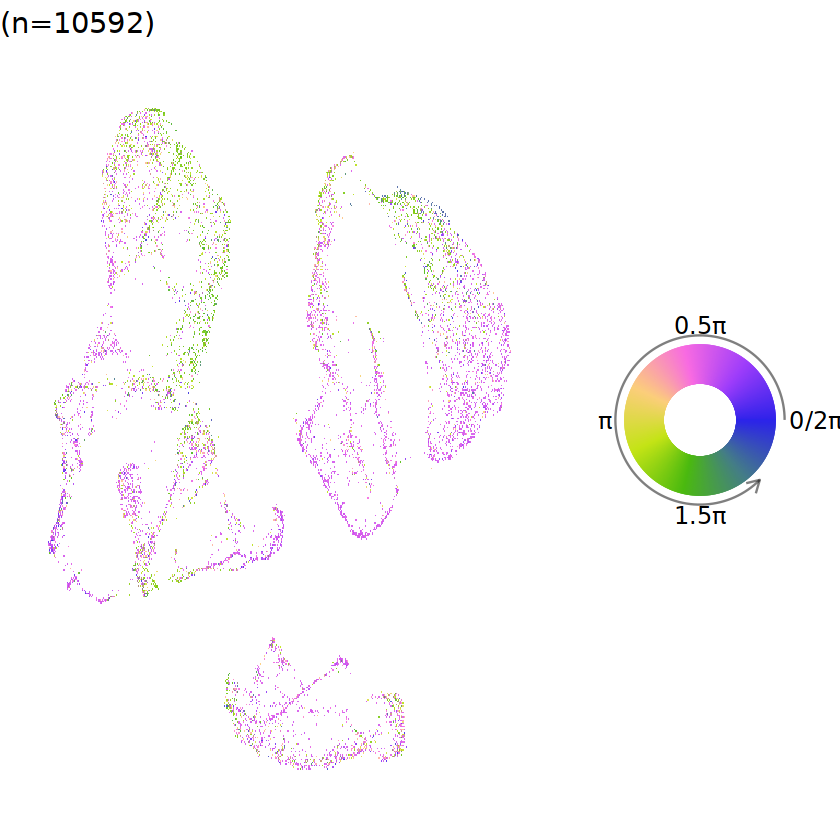

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


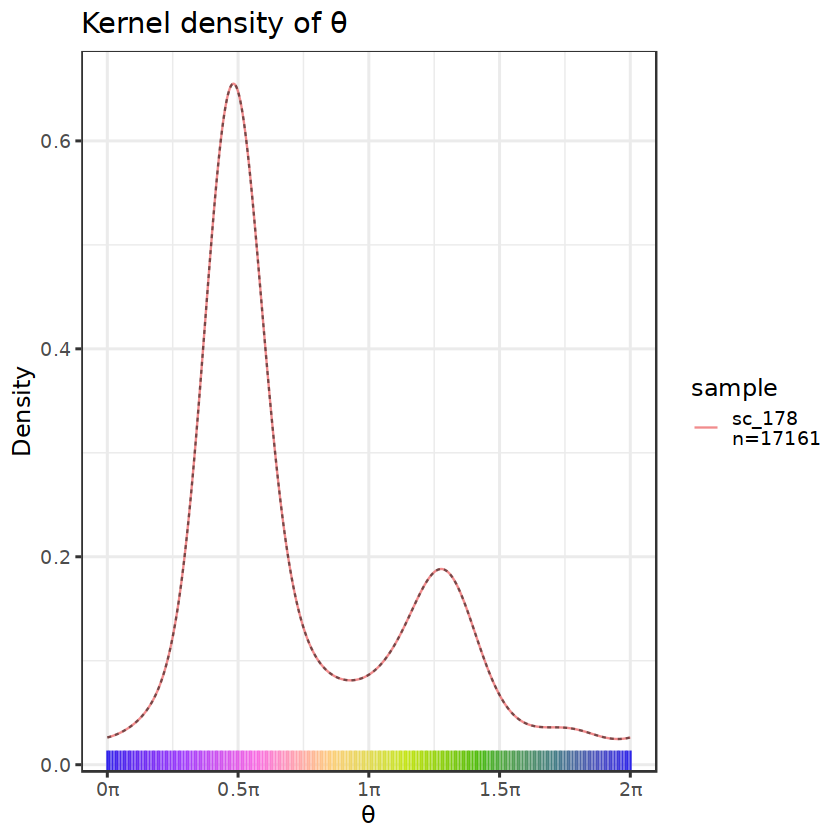

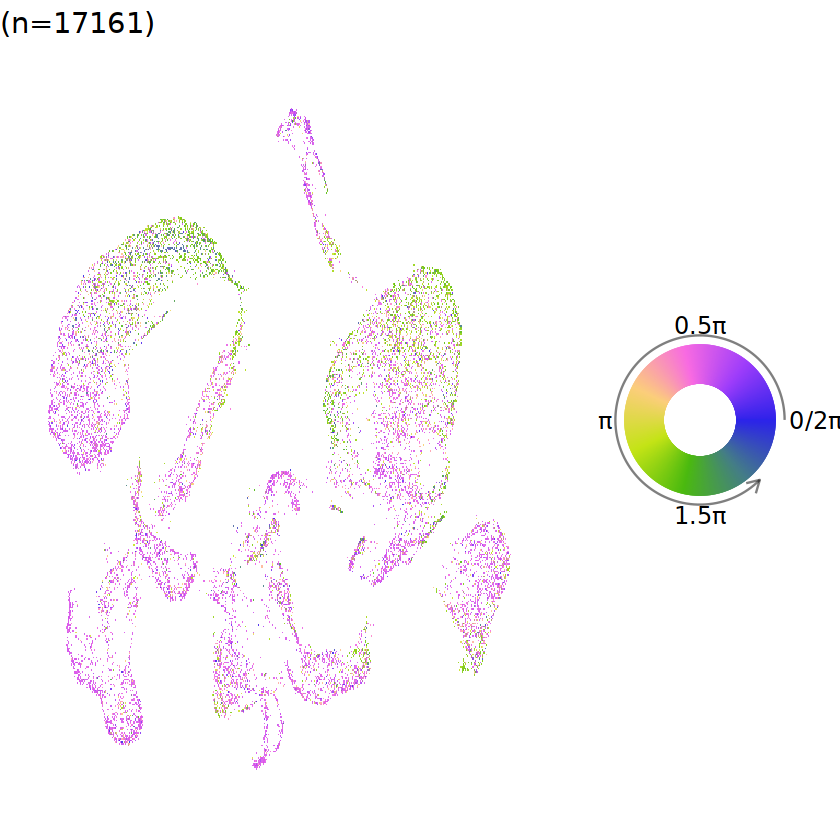

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


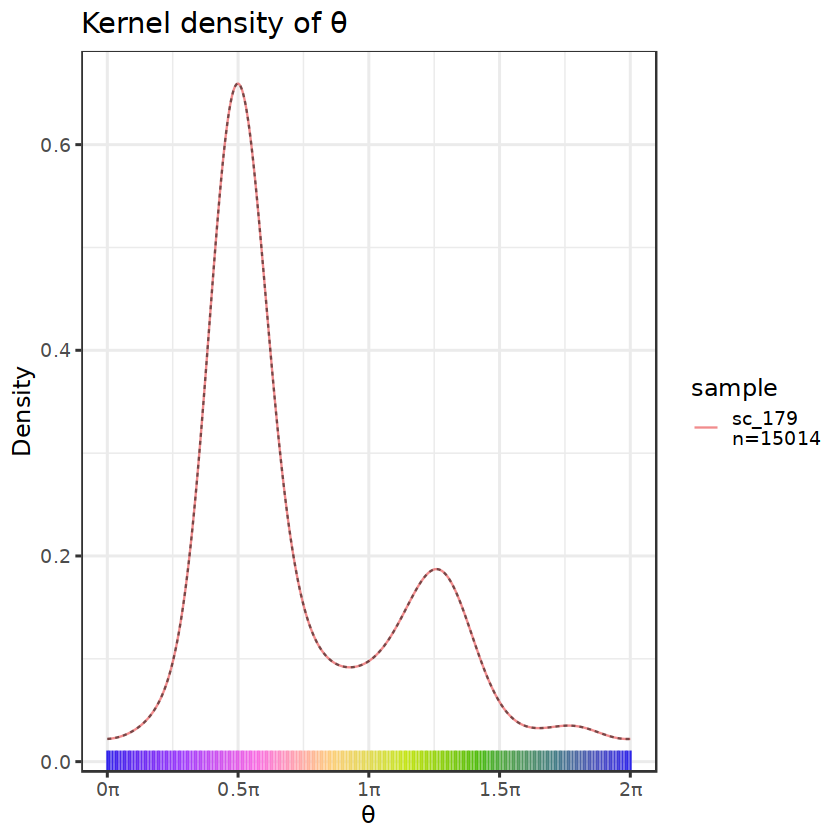

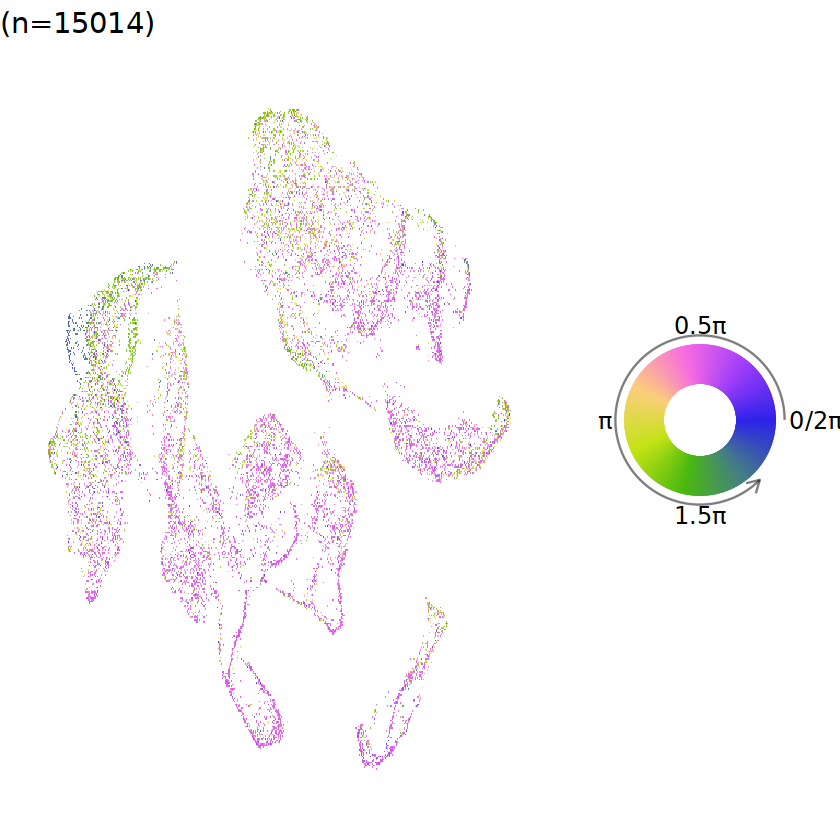

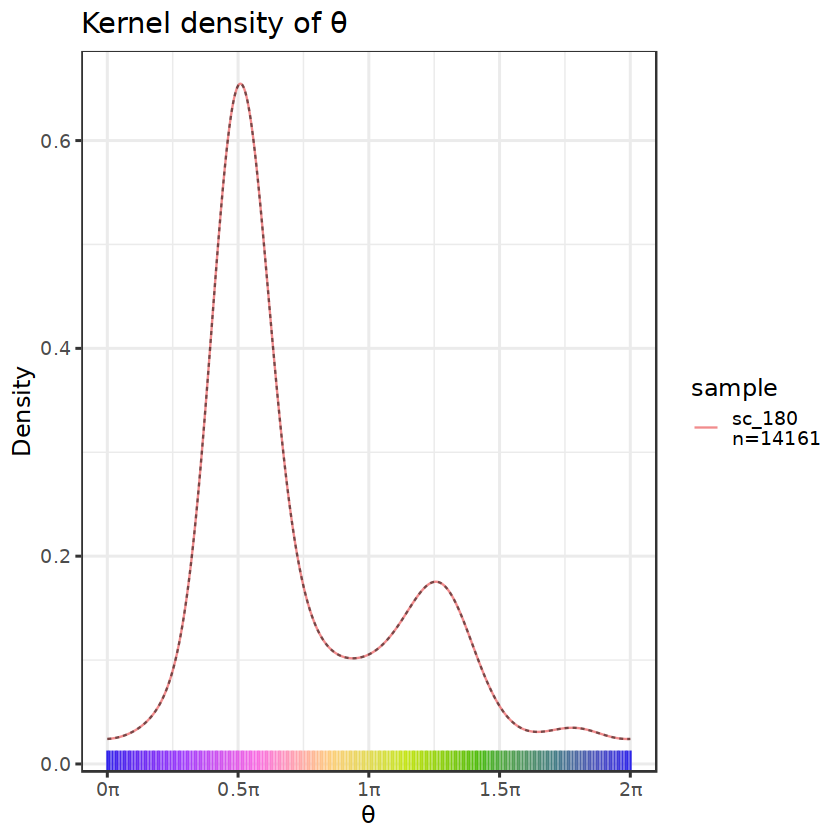

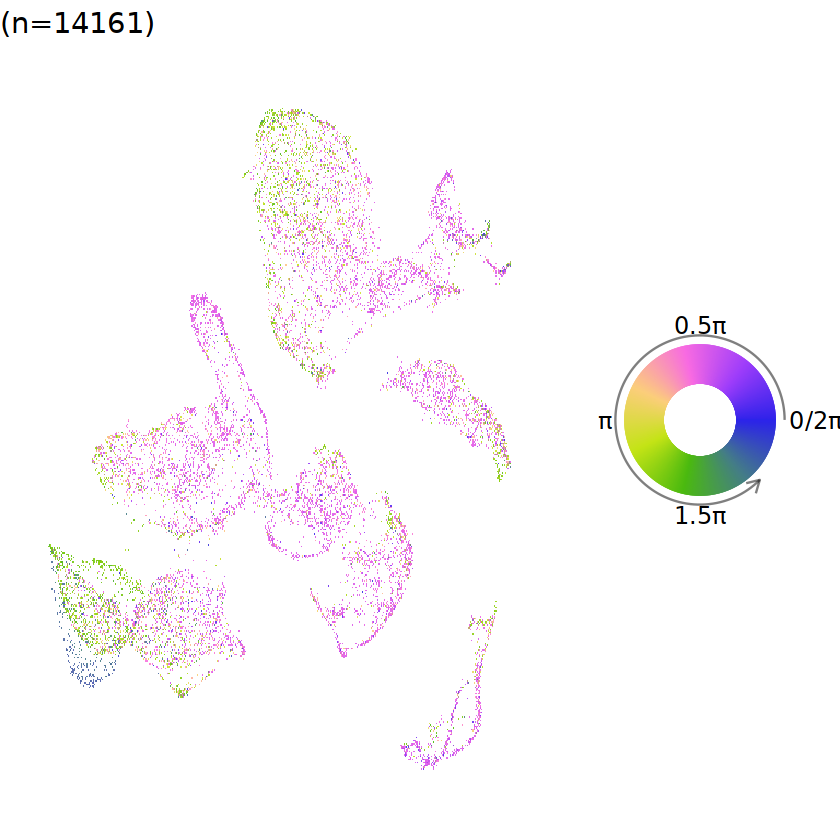

In [8]:
for (i in 1:length(sample.list)){
 run_tricycle(sample.list[i])
}

In [17]:
sample.list <- c("sc_57","sc_58","sc_59","sc_60","sc_61","sc_62","sc_63","sc_64","sc_66")

The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”
The number of projection genes found in the new data is 245.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


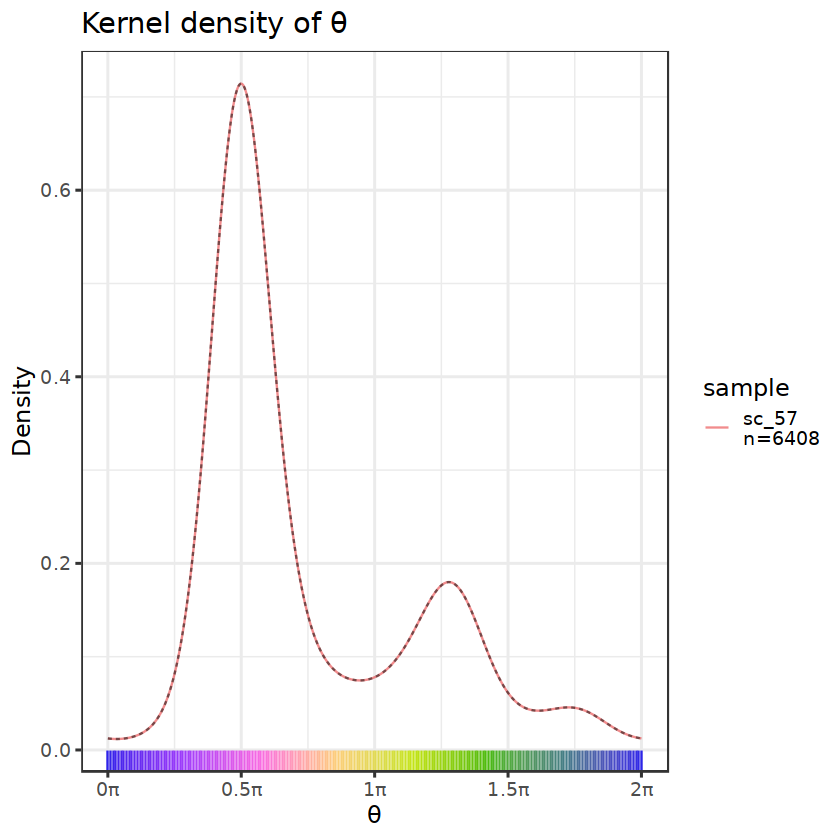

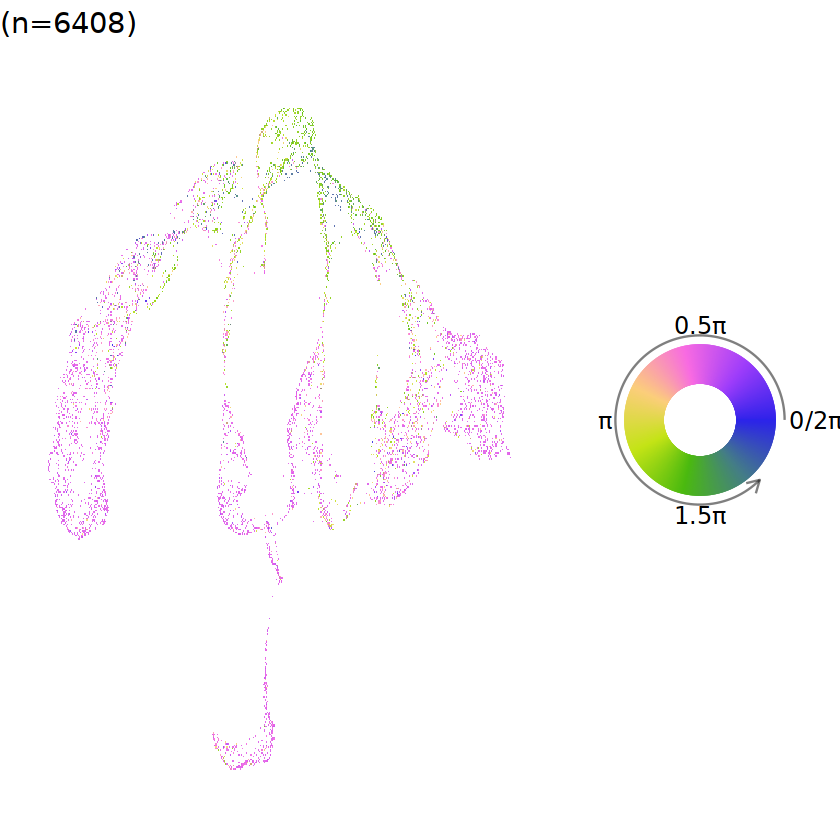

The number of projection genes found in the new data is 244.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


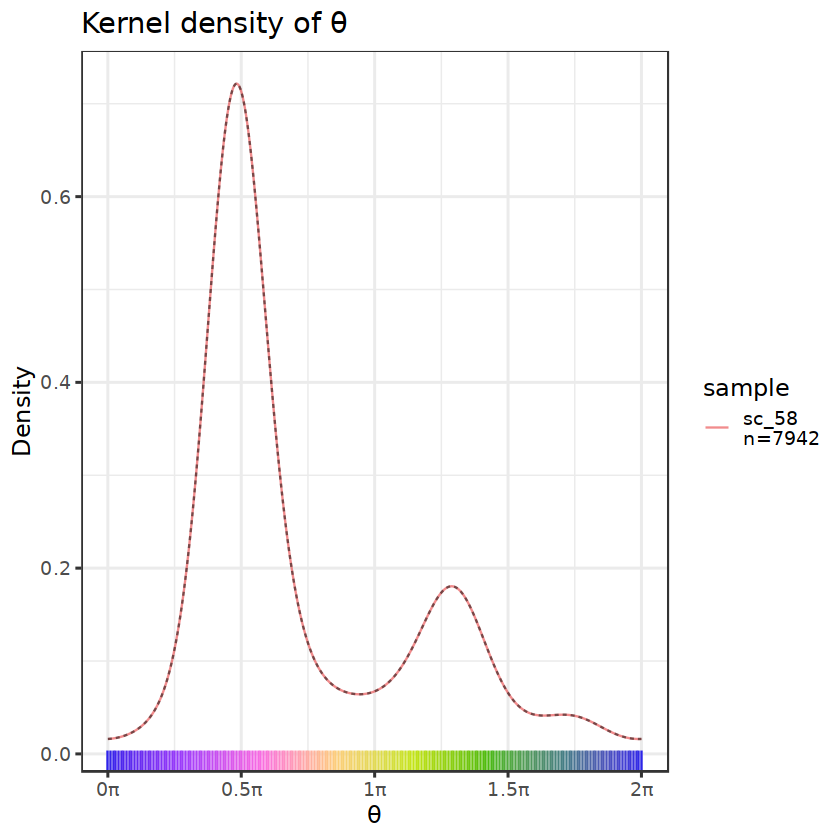

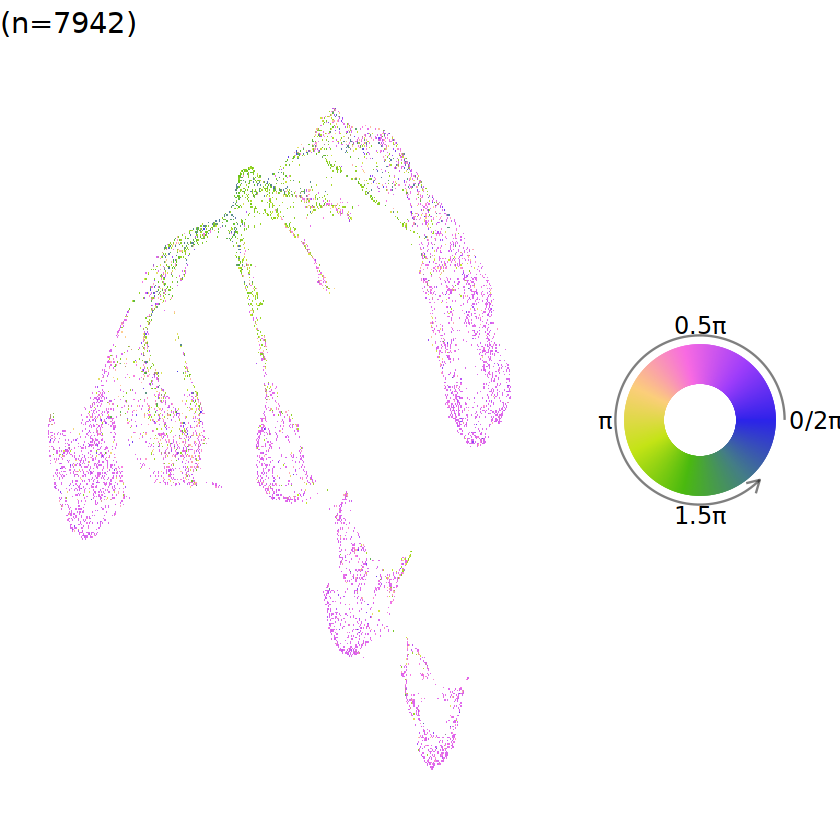

The number of projection genes found in the new data is 243.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


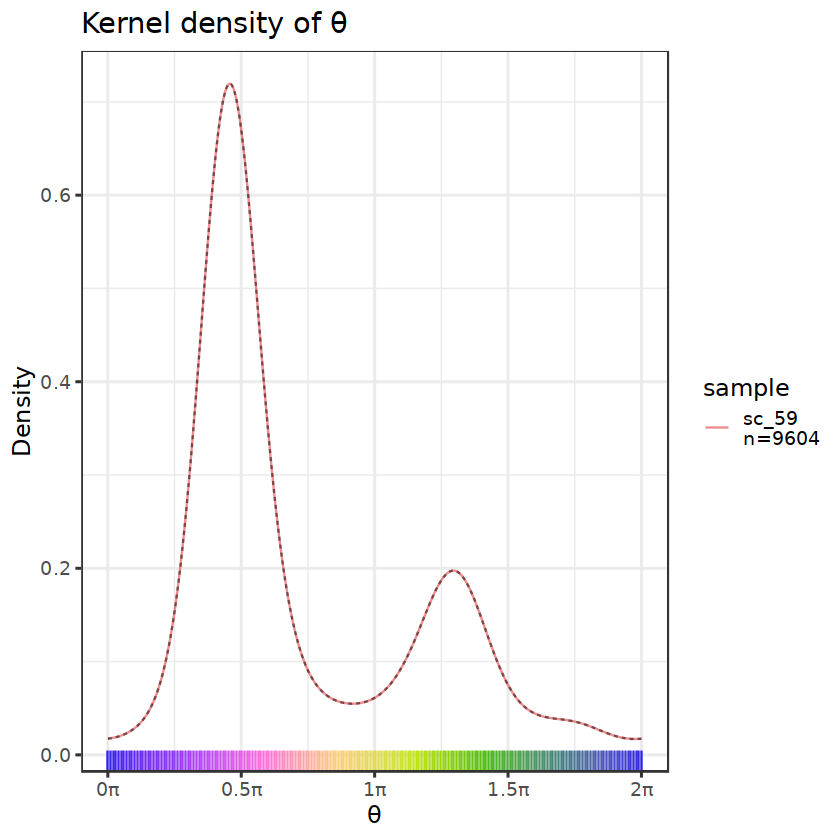

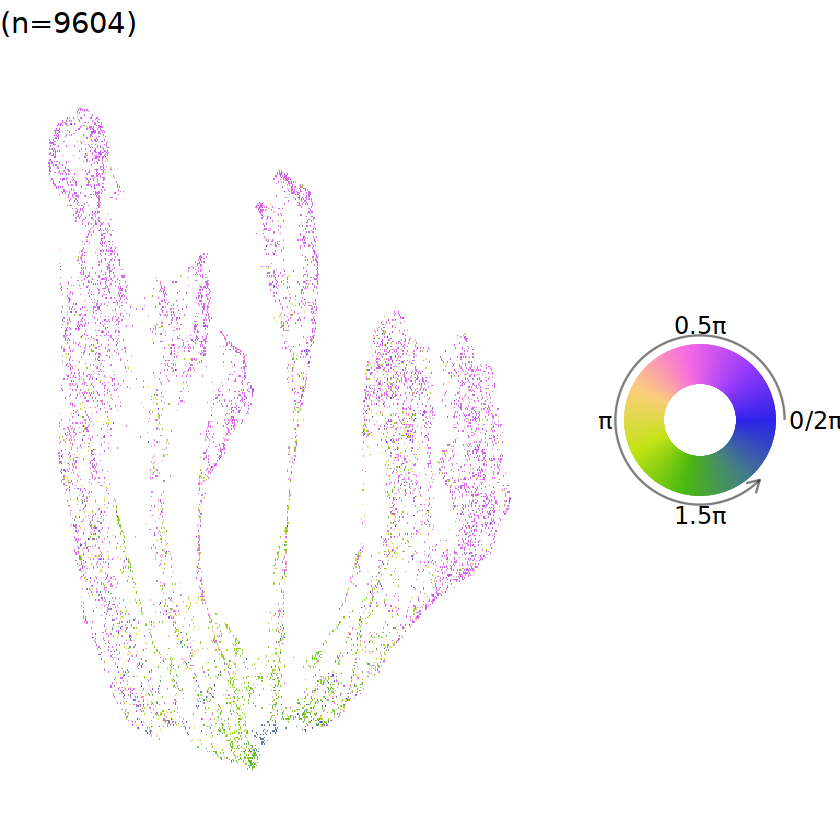

The number of projection genes found in the new data is 244.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


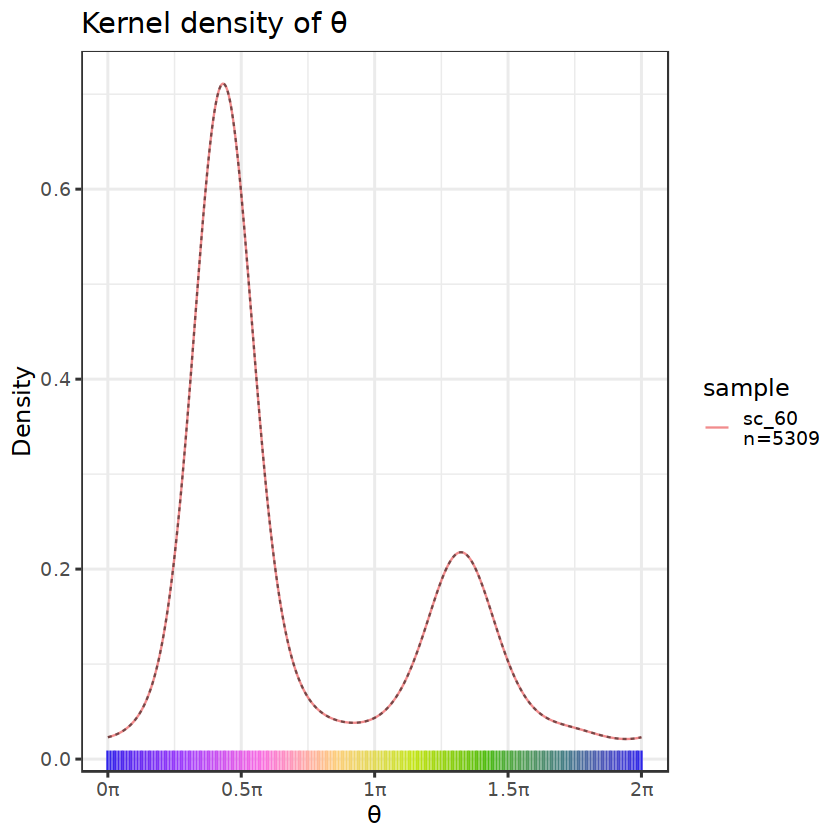

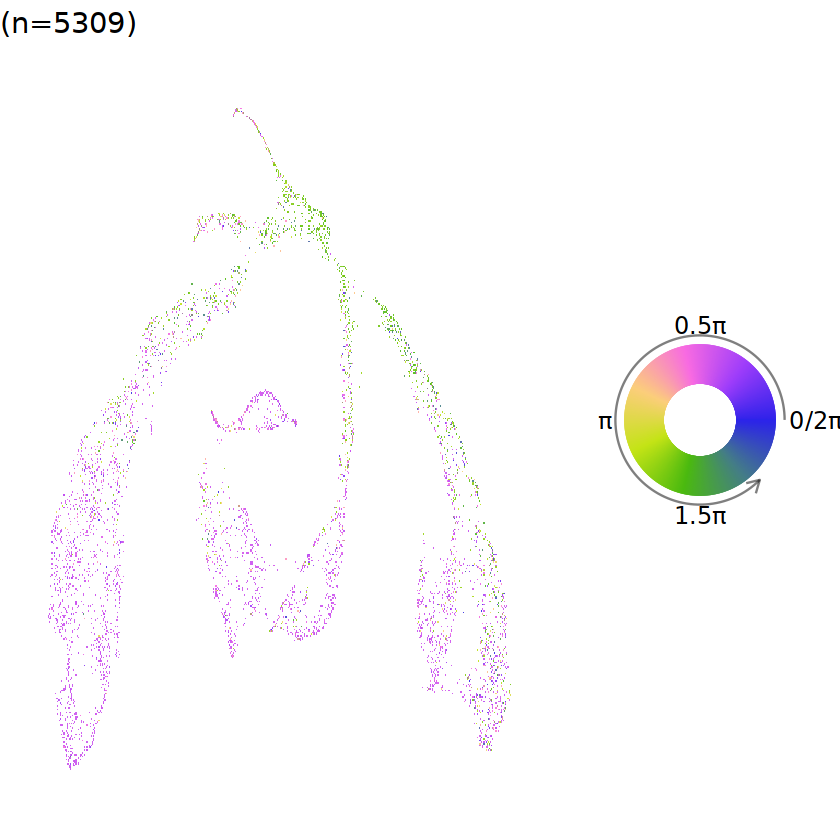

The number of projection genes found in the new data is 244.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


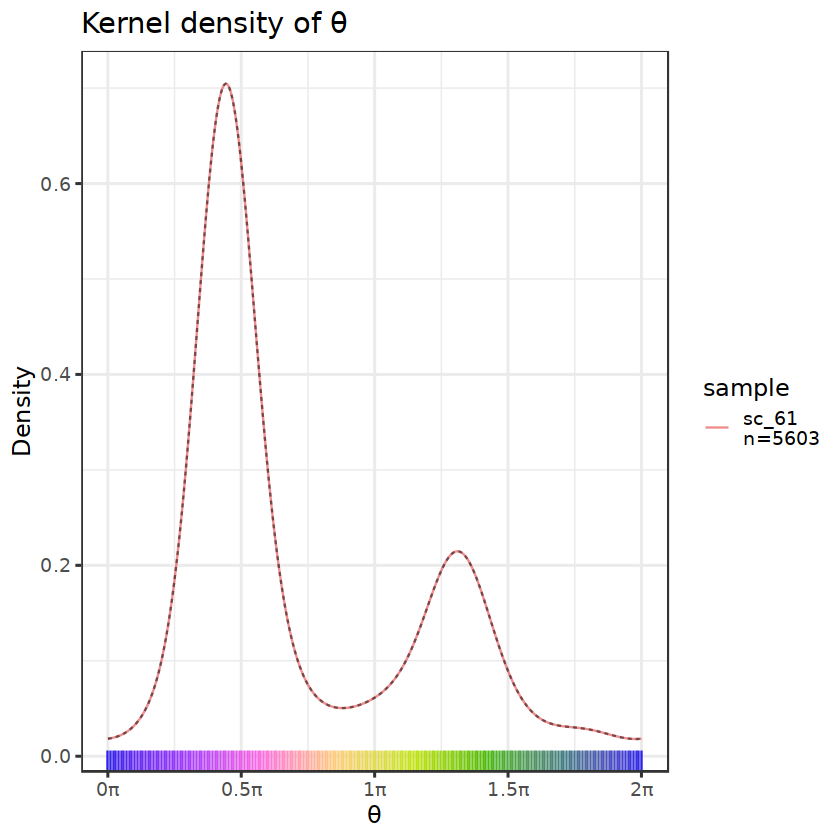

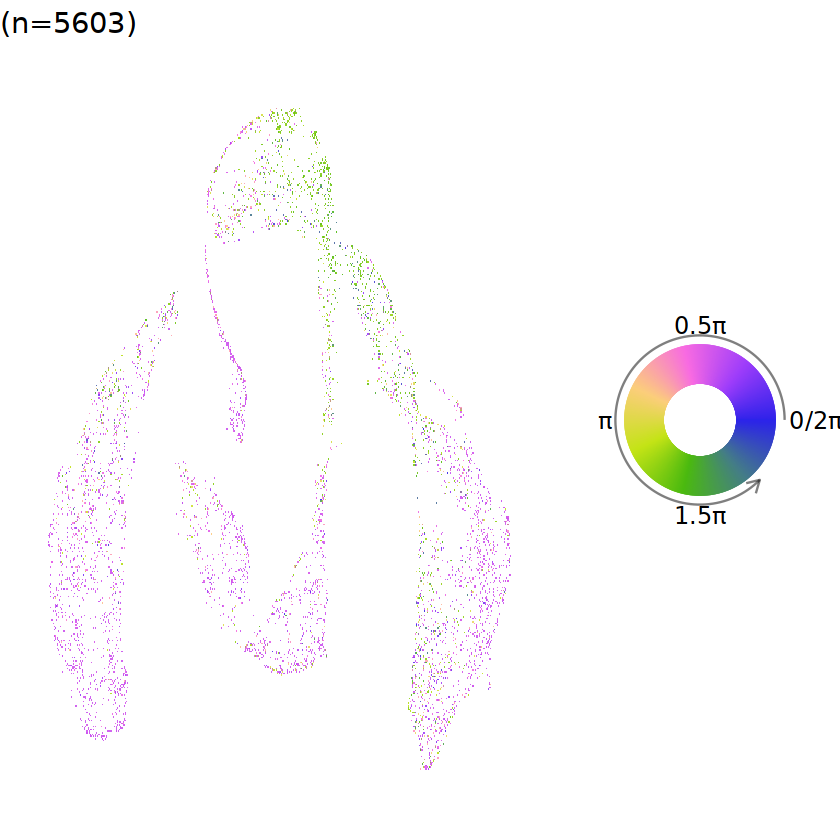

The number of projection genes found in the new data is 242.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


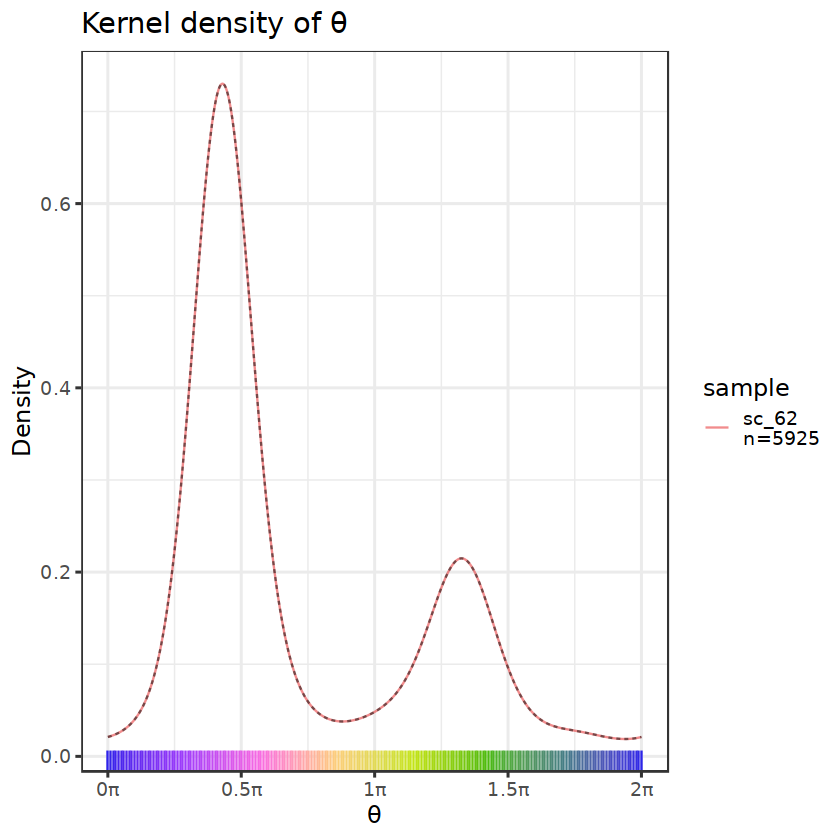

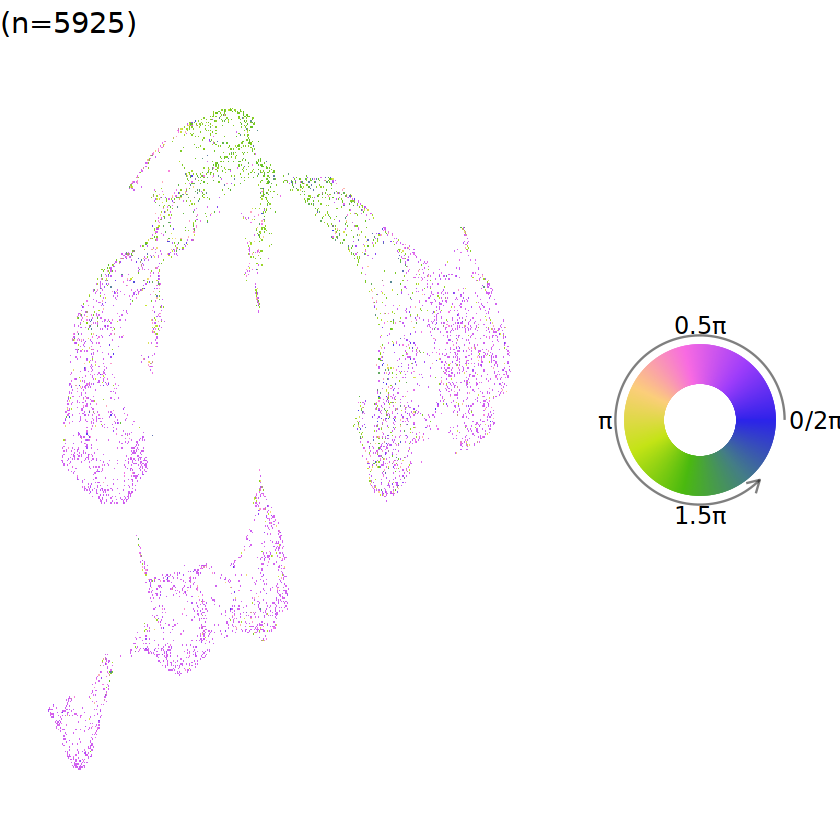

The number of projection genes found in the new data is 244.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


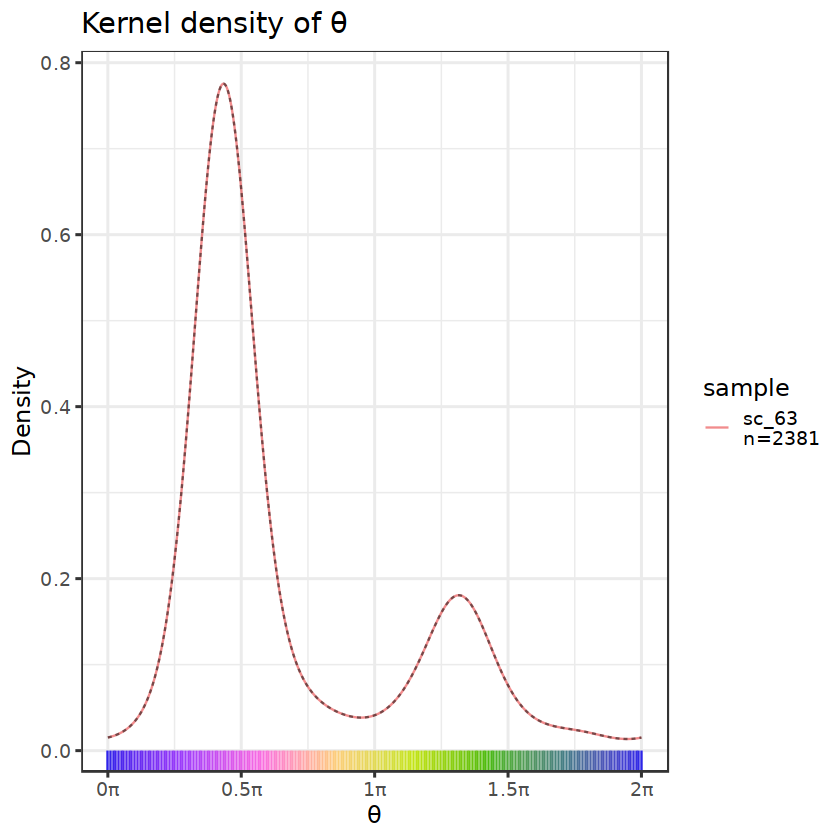

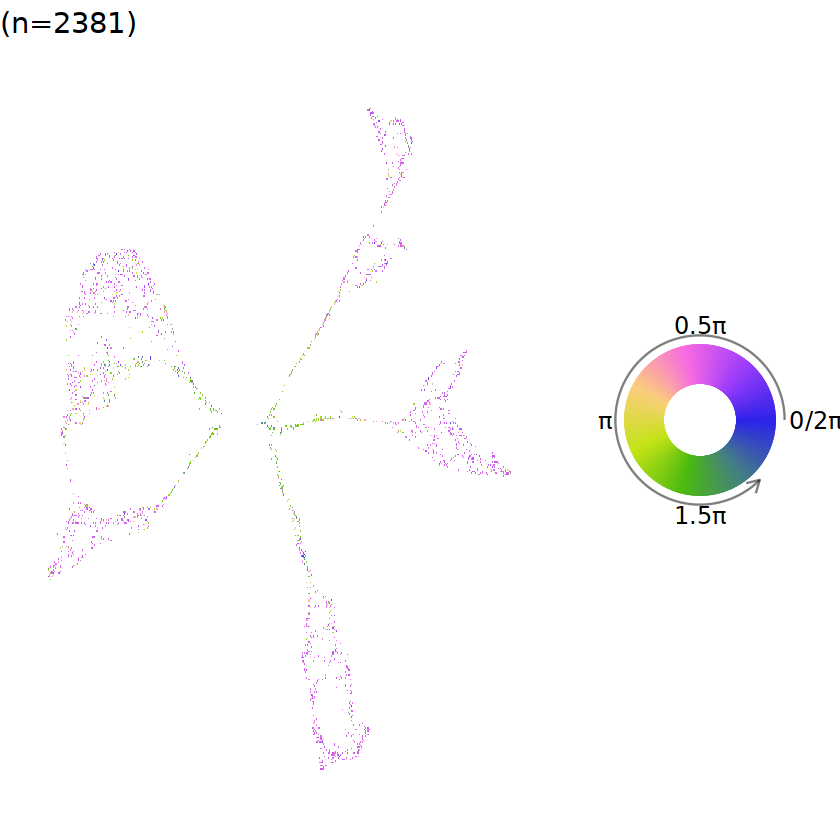

The number of projection genes found in the new data is 223.

Warning message in brewer.pal(nlevels(color_var.v), "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


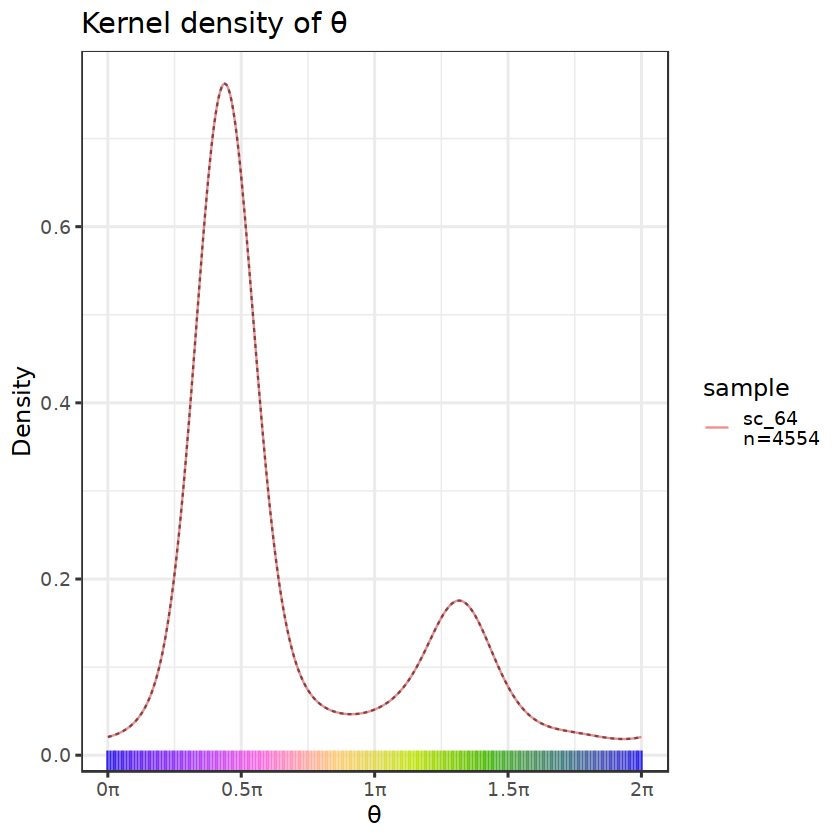

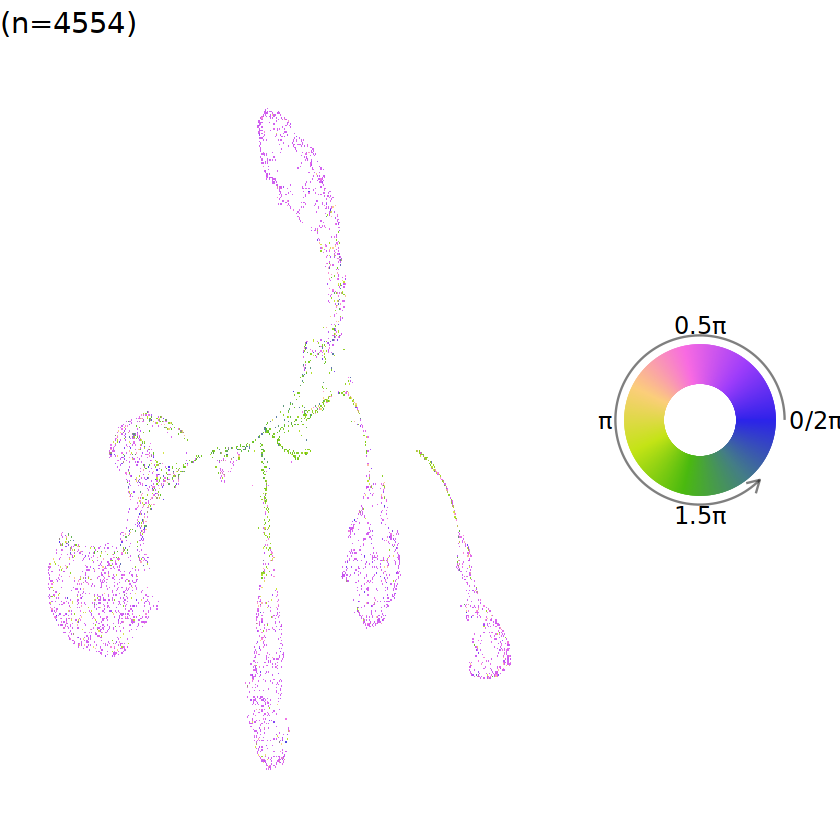

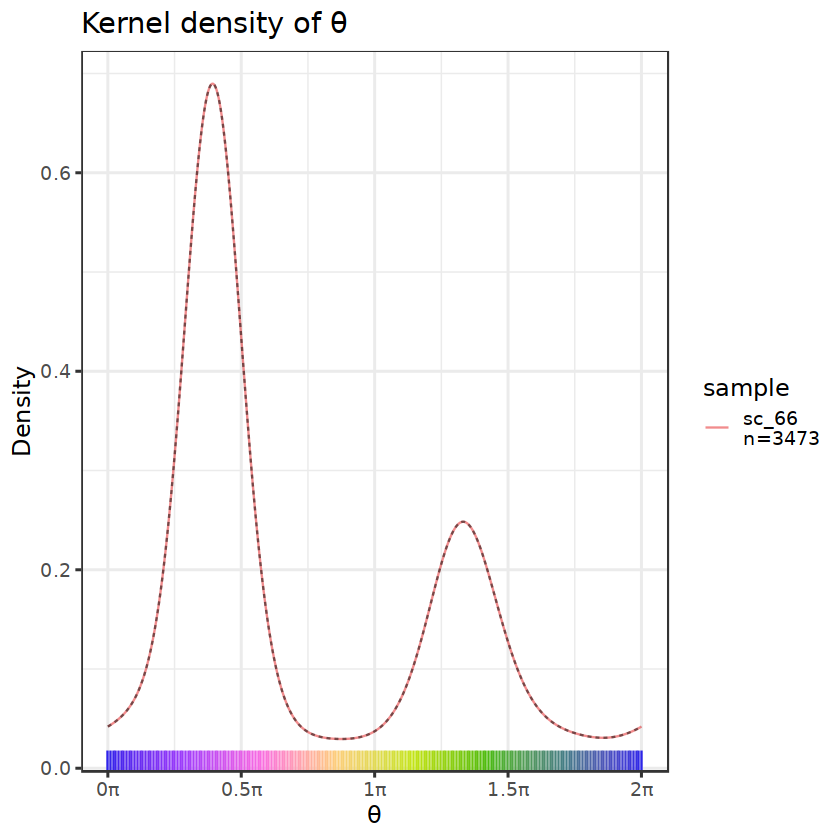

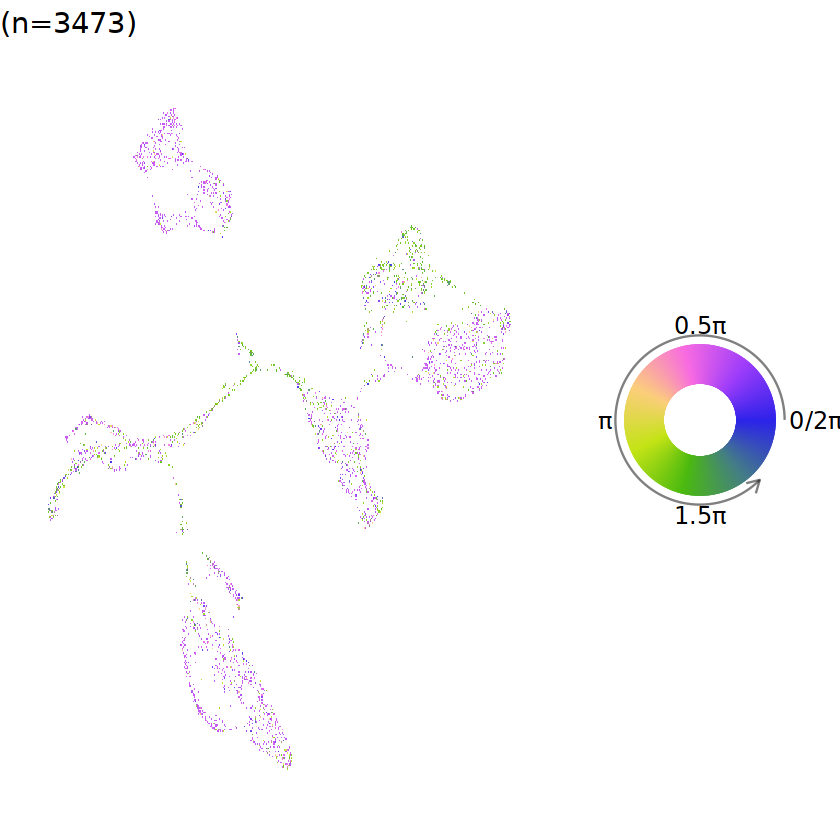

In [18]:
for (i in 1:length(sample.list)){
 run_tricycle(sample.list[i])
}